In [1]:
import pandas as pd
import numpy as np

import itertools
import calendar
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt

from datetime import date
from pandasql import sqldf

%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Assignment for Applicants to the Role: Product Analyst

Dataset is generated by an online food delivery business ‘Kaboom’ spread across multiple countries. Please help us understand more about the business in general from the following questions. 

Please focus on the logical explanation of your answer. You can use any tool of your choice to load/unload/query/analyze/visualize the data.
Please present your findings within 8 slides (including title) and share the code within 7 days of receiving the case study.

### Questions

1. Provide an exploratory analysis of the dataset answering the following:
- Define consumers who have the highest intent of purchase and which is the most cost effective channel to target them?
- What is the overall health of business and why? Which country contributes most to the bottomline and why?
- Create a consumer cohort analysis and identify the good and bad cohorts, Can you explain why?
2. Which cities provide an opportunity for Kaboom and why?
3. Create a customer segmentation using the behavioral and transactional data and propose a campaign strategy that aims to retain customers in the various segments.
4. Based on this data, what would you suggest a good KPI to measure customer retention?
5. What can be the primary KPIs for the company and what can you say about them?
6. Anything else you want to show or say!

## Data Definitions

- **Customer ID** : Unique ID per customer
- **Session ID** : Unique ID per sessions
- **Login id** : Assigned on customer login
- **Platform id** : platform of session i.e android, iOS, mweb, dweb
- **Duration** : Duration of every session
- **Transaction ID** : Unique ID Data captured on successful transaction on Web and app
- **Order ID** : Unique ID for every order entering operational system
- **Funnel Level**: Depth of funnel reached by a user in a session
- **Value**: Order value is denominated in integers at the lowest unit. e.g. 5000 GBP => 50 GBP (because the lowest unit in GBP is a penny, w/ 100 pence = 1 GBP)
- **currency_details.csv** a table with iso codes and exponents for currencies
- ** exponent ** column can be used to convert the integer amounts in the transactions table into cash amounts.
(e.g for 5000 GBP, exponent = 2, so we apply: 5000/(10^2) = 50 GBP

## Downloading the data

In [4]:
user_engagements = 'user_engagements.csv'
transaction_financials = 'transaction_financials.csv'
transaction_dimensions = 'transaction_dimensions.csv'
platforms = 'platforms.csv'
fx_rates_eur = 'fx_rates_eur.csv'
dim_channel = 'dim_channel.csv'
currency_details = 'currency_details.csv'
country_currency_mapping = 'country_currency_mapping.csv'
cities = 'cities.csv'

In [5]:
df_user_engagements = pd.read_csv(user_engagements)
df_transaction_financials = pd.read_csv(transaction_financials)
df_transaction_dimensions = pd.read_csv(transaction_dimensions)
df_platforms = pd.read_csv(platforms)
df_fx_rates_eur = pd.read_csv(fx_rates_eur)
df_dim_channel = pd.read_csv(dim_channel)
df_currency_details= pd.read_csv(currency_details)
df_country_currency_mapping = pd.read_csv(country_currency_mapping, header=None)
df_cities = pd.read_csv(cities)

In [6]:
dfs = {
    user_engagements: df_user_engagements,
    transaction_financials: df_transaction_financials,
    transaction_dimensions: df_transaction_dimensions,
    platforms: df_platforms,
    fx_rates_eur: df_fx_rates_eur,
    dim_channel: df_dim_channel,
    currency_details: df_currency_details,   
    country_currency_mapping: df_country_currency_mapping,
    cities: df_cities
}

## General information about the data

In [7]:
for name, df in dfs.items():
    print(name, df.shape)
    print(df.info(show_counts=True))
    print()
    print()

user_engagements.csv (1798608, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798608 entries, 0 to 1798607
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   sessionid        1156150 non-null  object 
 1   funnel_level     1156129 non-null  object 
 2   customerid       756131 non-null   object 
 3   userid           1156150 non-null  object 
 4   visit_duration   1156129 non-null  float64
 5   loginid          756144 non-null   object 
 6   platform         1798608 non-null  object 
 7   transaction_id   1398608 non-null  object 
 8   sessiondatetime  1156150 non-null  object 
dtypes: float64(1), object(8)
memory usage: 123.5+ MB
None


transaction_financials.csv (1000000, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   transac

**I found in `df_user_engagements` that there are `userid` and `customerid` fields, it looks strange, cause logically these variables should have the same meaning**

In [8]:
df_user_engagements.head()

,sessionid,funnel_level,customerid,userid,visit_duration,loginid,platform,transaction_id,sessiondatetime
0,03327977b7c2fba25bb131922983a882f40945b5,service,NaN,d4c7eb82ca3b613e395aaebc1559f4d007899bbc,0.00,NaN,WEB,NaN,2020-05-24 08:41:00
1,0b56a45b8dbd6cb5323a3a7b80be3eb48ea3f7ba,service,NaN,a07394c246f775799ca71492fcfd6ef6dce4a084,45.00,NaN,APP,NaN,2020-05-10 07:53:06
2,1d8de5efe1ac81ea2fa193dff9546d3af5af5764,service,NaN,4e13f53409a9887e936107dd3a016d9cfbc5a067,1.00,NaN,APP,NaN,2019-12-26 18:08:22
3,c9fff1caf5cef6054e76136e5f523974332baea5,service,NaN,f3ad470495b9cd4623edd79a151ad834c8b21c75,1199.00,NaN,APP,NaN,2019-12-23 19:55:24
4,d7bdc47e1b3ad58e9f80a87c5d5f3a3a2c7cebac,service,NaN,84fa728e41e8b6edd935f275d35772ad294face1,3.00,NaN,APP,NaN,2019-12-29 12:44:49


In [9]:
df_user_engagements.nunique() # Unique values within columns

sessionid          1009531
funnel_level             5
customerid          639381
userid              873503
visit_duration        5454
loginid             635887
platform                 3
transaction_id      794738
sessiondatetime     992339
dtype: int64

In [10]:
df_user_engagements.isna().sum() # Gaps within columns

sessionid           642458
funnel_level        642479
customerid         1042477
userid              642458
visit_duration      642479
loginid            1042464
platform                 0
transaction_id      400000
sessiondatetime     642458
dtype: int64

Let's look at categorical values within `df_user_engagements`

In [11]:
for colname in df_user_engagements.select_dtypes(include='object').columns:
    print(str(colname) + '\n\n' + str(df_user_engagements[colname].value_counts()) + '\n' + '-' * 50 + '\n')

sessionid

sessionid
54f0fc820c99e0326a0a77ff0a2a3fcdc1fdf480    438
57b7c4fc0430e9c05ee599e24027c91cdc5b8406    438
b86dea165803f51c7c600e804fd5d30f70c05550    438
7d3d9398e0e373203201a4058be0139ccd23718b    219
2212d583bcfd76c95642d2b586a07734b37a62cd    219
                                           ... 
16c055bc48a04f4fc0795b430305baed24b5bb0c      1
0c013be20a30a7f7748088709ed3ed26a379523b      1
012b40d5fcd59b55f8e78e6f0c241b08b2aa05fa      1
7ff355aea556da5cfc0c9d7d6a232d31557aaeba      1
3830b364bc410c5f776fdbca39c8de3768a2519e      1
Name: count, Length: 1009531, dtype: int64
--------------------------------------------------

funnel_level

funnel_level
service         518159
confirmation    415788
menu            152832
checkout         51246
start            18104
Name: count, dtype: int64
--------------------------------------------------

customerid

customerid
ff0fe209a93a1271c7d8e01f8e8238004652f092    174
6c268ce1c68c02ab85c4b2b6feea70448b64ee02     62
61fa6beeae25ed2f2

## Data Processing

In [12]:
df_user_engagements.head()

,sessionid,funnel_level,customerid,userid,visit_duration,loginid,platform,transaction_id,sessiondatetime
0,03327977b7c2fba25bb131922983a882f40945b5,service,NaN,d4c7eb82ca3b613e395aaebc1559f4d007899bbc,0.00,NaN,WEB,NaN,2020-05-24 08:41:00
1,0b56a45b8dbd6cb5323a3a7b80be3eb48ea3f7ba,service,NaN,a07394c246f775799ca71492fcfd6ef6dce4a084,45.00,NaN,APP,NaN,2020-05-10 07:53:06
2,1d8de5efe1ac81ea2fa193dff9546d3af5af5764,service,NaN,4e13f53409a9887e936107dd3a016d9cfbc5a067,1.00,NaN,APP,NaN,2019-12-26 18:08:22
3,c9fff1caf5cef6054e76136e5f523974332baea5,service,NaN,f3ad470495b9cd4623edd79a151ad834c8b21c75,1199.00,NaN,APP,NaN,2019-12-23 19:55:24
4,d7bdc47e1b3ad58e9f80a87c5d5f3a3a2c7cebac,service,NaN,84fa728e41e8b6edd935f275d35772ad294face1,3.00,NaN,APP,NaN,2019-12-29 12:44:49


In [13]:
df_user_engagements.shape[0]

1798608

**1.SessionId**

In [14]:
df_user_engagements['sessionid'].shape[0]

1798608

In [15]:
df_user_engagements['sessionid'].unique().shape[0]

1009532

In [16]:
df_user_engagements[df_user_engagements['sessionid'].isna()].head()

,sessionid,funnel_level,customerid,userid,visit_duration,loginid,platform,transaction_id,sessiondatetime
38618,NaN,NaN,NaN,NaN,NaN,NaN,APP,65ea7a15ec454b2f1f1b4e1716266a6f0c989df5,NaN
38619,NaN,NaN,NaN,NaN,NaN,NaN,APP,722dc9b76e7d2805a99f73c1f33d38827946f590,NaN
38620,NaN,NaN,NaN,NaN,NaN,NaN,APP,bf596517de4799578abf2e8923d79b1f5595d769,NaN
38621,NaN,NaN,NaN,NaN,NaN,NaN,APP,4c99c94968fc834750bc818772e4b487652f16b2,NaN
38622,NaN,NaN,NaN,NaN,NaN,NaN,APP,31282679ec89f8a1e37b8462b57cf4826c6a5837,NaN


In [17]:
df_user_engagements[df_user_engagements['sessionid'].isna()].shape[0]

642458

In [18]:
df_user_engagements[df_user_engagements['sessionid'].isna()]['transaction_id'].unique().shape[0]

625108

We could see **642.458 (625.108) Null values** in `sessionid`, I believe that this situation could occur, when users are unauthorized within the session

Let's check the example of random %SessionId

In [19]:
def get_samples(df, col, col_value):
    """
    Return rows from df where df[col] == col_value
    
    Parameters:
        df - dataframe
        col - selector column
        col_value - selector column value
    
    Returns:
        rows from df where df[col] == col_value
    """
    return df[df[col] == col_value] 

In [20]:
get_samples(df_user_engagements, 'sessionid', '00309a61519a28e79fb97f829afb55cba05bc667')[:6]

,sessionid,funnel_level,customerid,userid,visit_duration,loginid,platform,transaction_id,sessiondatetime
504396,00309a61519a28e79fb97f829afb55cba05bc667,service,b0340bd1be53df82ee7e21f752c31021b1a30bc2,214dbc2b46ea0b544c0a3334ae630d0994a669ac,174.00,fef146975ff5da3ab31854cca6105a3539708551,APP,960374fd59de0d8e3be2553316b259a8936fee13,2020-05-04 07:29:52
504397,00309a61519a28e79fb97f829afb55cba05bc667,service,401656664da58837a223dea38820a87d8ee6cff0,214dbc2b46ea0b544c0a3334ae630d0994a669ac,174.00,0a431d51f522d7b4b8f63dae2697f00fa2fba13b,APP,960374fd59de0d8e3be2553316b259a8936fee13,2020-05-04 07:29:52
504398,00309a61519a28e79fb97f829afb55cba05bc667,service,ede2c4a03adb71c84bff5b4d30f8163e037edc7b,214dbc2b46ea0b544c0a3334ae630d0994a669ac,174.00,99282d7f04a1880107b3548f22424f1c45488d57,APP,960374fd59de0d8e3be2553316b259a8936fee13,2020-05-04 07:29:52
504399,00309a61519a28e79fb97f829afb55cba05bc667,service,03230797bbc560b4a05b2364a4e5fabc781ed1df,214dbc2b46ea0b544c0a3334ae630d0994a669ac,174.00,770d8de2844f16b22103c0d07d4a5d59d1f0d108,APP,960374fd59de0d8e3be2553316b259a8936fee13,2020-05-04 07:29:52
504400,00309a61519a28e79fb97f829afb55cba05bc667,service,bd1efe62f35dda014d2f21ec52a510b1f241fac7,214dbc2b46ea0b544c0a3334ae630d0994a669ac,174.00,7ca3a59a972f9abfefc103abb45591f2c15ec427,APP,960374fd59de0d8e3be2553316b259a8936fee13,2020-05-04 07:29:52
504401,00309a61519a28e79fb97f829afb55cba05bc667,service,da201e5dab6bdc0a853cfeddf83a888e5359851f,214dbc2b46ea0b544c0a3334ae630d0994a669ac,174.00,3920ade541984a9afe49ec3a75809049104960f5,APP,960374fd59de0d8e3be2553316b259a8936fee13,2020-05-04 07:29:52


**I see that `customerid` and `loginid` are different while `sessionid` and `userid` are the same**

In [21]:
# check stats for each unique sessionid
query = """ 
SELECT 
    sessionid,
    COUNT(*) AS cnt_sessionid,
    COUNT(transaction_id) AS cnt_transaction_id,
    COUNT(DISTINCT transaction_id) AS cnt_unique_transaction_id,
    COUNT(funnel_level) AS cnt_funnel_level,
    COUNT(DISTINCT funnel_level) AS cnt_unique_funnel_level
FROM df_user_engagements
GROUP BY sessionid
ORDER BY cnt_unique_funnel_level DESC
"""
tdf = sqldf(query) 
tdf

,sessionid,cnt_sessionid,cnt_transaction_id,cnt_unique_transaction_id,cnt_funnel_level,cnt_unique_funnel_level
0,fffffdd8ad8a9792b5680327a66b6fd51e4f38e2,1,1,1,1,1
1,fffff2d92ba00a584abb66b6985dbf29c574e258,1,1,1,1,1
2,ffffebb64e01f665afc135b8b0f9dcd4baf295ee,1,0,0,1,1
3,ffffd7d86c5a8e94a934f962fa99d5fe590d8949,1,1,1,1,1
4,ffffcf438f08f88889bf86ca2ed02809c4612d2b,1,0,0,1,1
...,...,...,...,...,...,...
1009527,0000293303661324d9fdc4f876886dd1a990a55a,1,1,1,1,1
1009528,000028a3d1f3b52fa0a5abc701093793c1ecc1c7,2,2,1,2,1
1009529,000021658f0b8a1e543c7cbccaf49128a6fa36a8,1,0,0,1,1
1009530,00000458bf8df8985f01ef736b4f3e4ebcd60ea7,1,0,0,1,1


In [22]:
tdf['cnt_unique_funnel_level'].value_counts()

cnt_unique_funnel_level
1    1009531
0          1
Name: count, dtype: int64

**I see, that every `sessionid` has only one `funnel_level`**

In [23]:
tdf['cnt_unique_transaction_id'].value_counts() # 2 unique transaction within one session in 71 cases 

cnt_unique_transaction_id
1         609460
0         400000
2             71
625108         1
Name: count, dtype: int64

In [24]:
tdf[tdf['cnt_unique_transaction_id'] == 2][:5]

,sessionid,cnt_sessionid,cnt_transaction_id,cnt_unique_transaction_id,cnt_funnel_level,cnt_unique_funnel_level
2616,ff56663ce6c76f7df463d4fc8d589d7826853e65,2,2,2,2,1
9203,fdac67d77885fac97883a003b89ee22123df9836,2,2,2,2,1
11648,fd11579bb67331558bf2201c732d32a5add8585c,2,2,2,2,1
13228,fcae7a99d1d2ea092067a8775890472c8e663011,2,2,2,2,1
66400,ef2461c94f566cc23d1a0eb53c9a82ad2a3bb773,4,4,2,4,1


In [25]:
get_samples(df_user_engagements, 'sessionid', 'fd11579bb67331558bf2201c732d32a5add8585c')

,sessionid,funnel_level,customerid,userid,visit_duration,loginid,platform,transaction_id,sessiondatetime
537438,fd11579bb67331558bf2201c732d32a5add8585c,confirmation,656c8678d8fc7558579506f841d96e7515eeb56e,2066e8297e08320ada764729740864793a581d53,266.00,39d74804772814d2dc38c6079b1f5007030f21fa,APP,69a5cf583c98de4b3523c0fe4bc28ae5cc7d71bd,2019-09-29 09:52:39
537439,fd11579bb67331558bf2201c732d32a5add8585c,confirmation,656c8678d8fc7558579506f841d96e7515eeb56e,2066e8297e08320ada764729740864793a581d53,266.00,39d74804772814d2dc38c6079b1f5007030f21fa,APP,c2ab1c77f3382c0691bf44d4a64aec102ba98196,2019-09-29 09:17:39


My conclusion - **data is not clean**
1. We have `customerid` duplicates
2. We see `transactionid` duplicates
3. We see `sessionid` duplicates

**I think it’s time to take a closer look at `transaction_id`, cause this column is the connecting link with the transactions tables**

**2. Transaction_id**

In [26]:
df_grouped_transactions = df_user_engagements.groupby(by='transaction_id', as_index=False).agg(
    n_transactionids=pd.NamedAgg(column='transaction_id', aggfunc='count'),
    n_sessionids=pd.NamedAgg(column='sessionid', aggfunc='count'),
    n_unq_loginids=pd.NamedAgg(column='loginid', aggfunc='nunique'),
    n_unq_userids=pd.NamedAgg(column='userid', aggfunc='nunique'),
    n_unq_customerids=pd.NamedAgg(column='customerid', aggfunc='nunique'),
)

df_grouped_transactions.sort_values(by='n_transactionids', ignore_index=True, ascending=False)

,transaction_id,n_transactionids,n_sessionids,n_unq_loginids,n_unq_userids,n_unq_customerids
0,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,220,219,219,1,219
1,ae8fbaefbf972bebef39b062cfbad9e213af1c11,220,219,219,1,219
2,335399445133f0d89a4a8f2518b0069959081fa0,220,219,219,1,219
3,1633a23121657e06efbb51548fd65466faf503e7,220,219,219,1,219
4,5a72d6b6a897428d9dbc4bb42927abf2ac483e11,220,219,219,1,219
...,...,...,...,...,...,...
794733,a3e4392e8b880f92b23843e05907356cfbd9eede,1,1,1,1,1
794734,a3e3f24cd96eb1328c539c6d0f3e35fed73f4ba2,1,0,0,0,0
794735,a3e3d938f4105698887b994b1b191a7c83d12b6a,1,1,1,1,1
794736,3eae5917dd12d8c174e36f724be1762b15581ae4,1,0,0,0,0


**Let's look at `n_unique_userids`, `n_unique_customerids`, `n_unique_loginids` within the same transaction**

In [27]:
df_grouped_transactions['n_unq_userids'].value_counts().sort_values()

n_unq_userids
2        64
0    186454
1    608220
Name: count, dtype: int64

In [28]:
# double check
utr = set(df_user_engagements[df_user_engagements['userid'].notna()]['transaction_id'])
df_user_engagements[~df_user_engagements['transaction_id'].isin(utr)]['transaction_id'].unique().shape

(186454,)

It shows us, that there are always **one `userid` per one `transactionid`** in most cases and for **186 454 `transaction_id`** there no information about user 

In [29]:
df_grouped_transactions['n_unq_customerids'].value_counts()[:10]

n_unq_customerids
1    497215
0    186470
2     93235
3     13739
4      2500
5       751
6       285
7       149
8        78
9        76
Name: count, dtype: int64

Comment to the data above: we have **497 215 transactions with 1 unique `customerid`, 13 739 transactions with 3 unique `customerids` and etc**

In [30]:
df_grouped_transactions['n_unq_loginids'].value_counts()[:10]

n_unq_loginids
1    510459
0    186458
2     82005
3     12376
4      2204
5       635
6       232
7       102
9        55
8        50
Name: count, dtype: int64

Comment to the data above: we have **510 459 transactions with 1 unique `loginid`, 82 005 transactions with 3 unique `loginids` and etc**

In [31]:
def size_calculation(df, groupby_columns, sort_columns, ascending=True):
    """
    Return grouped column with its size's value
    
    """
    
    return df.groupby(groupby_columns)                                        \
        .size()                                                               \
        .reset_index(name='cnt')                                              \
        .sort_values(by=sort_columns, ignore_index=True, ascending=ascending)

In [32]:
size_calculation(df_grouped_transactions, groupby_columns=['n_unq_customerids','n_unq_loginids', 'n_unq_userids'], 
                 sort_columns=['cnt'], ascending=False)[:10]

,n_unq_customerids,n_unq_loginids,n_unq_userids,cnt
0,1,1,1,497166
1,0,0,0,186454
2,2,2,1,81944
3,3,3,1,12374
4,2,1,1,11278
5,4,4,1,2203
6,3,1,1,1364
7,5,5,1,635
8,4,1,1,296
9,6,6,1,232


We see once again that `customerids` and `loginids` are duplicated, example: 81 944 transactions are connected to unique transaction and 2 different `customerids` and 2 different `loginids`

In [33]:
tdf = size_calculation(df_user_engagements, ['customerid', 'transaction_id'], ['cnt'])
tdf

,customerid,transaction_id,cnt
0,00000810d8b463c799f19f7bec9275b618d8111d,7ea03a65c20b8f58258839ed52737c8529d0037c,1
1,aa6fde7cb3e46c438e18cfc7a3449b880637fb52,3ce60d8579d4d991a397d0a833d3e6f935e87604,1
2,aa6fe494460d26a6c549db2f78ac647d82e2b060,7260da4980205894cb28e67b951417c6901aaedf,1
3,aa6fe649ca2f73e5d19e8c6c705508e6163f8051,7bcdc6b8533f74bb10f7e95cd06fb3eaecc9f121,1
4,aa6ff678e4178d270d30a0ad3c18db6a8cd68b9a,327e01a8d27af6262e03cce60e1670641d4b5eb9,1
...,...,...,...
749708,c55558c7cafd310f376ccae2bb782cf99d6bf153,3a465a6f6e04a0b22a9ba5630e7670dbf2a13b4d,3
749709,0a6238abf71150fb94c3881edd225b7807a4bef9,b1f4138f379d9a70a6fc2bc382c3c5a2acd8d2cd,3
749710,471fed0aace2c6037c2c12861dee3059c6b5fc60,e68e4e67c94d8684218dc942a6b40771fce8b1e9,4
749711,72aadbd7f858c6a848971991ff4d23411552eaef,89bf7ba340fe1f191db73d896f33067cad3485bc,4


In [34]:
trdf = size_calculation(tdf, ['transaction_id'], ['cnt'], ascending=False)
trdf

,transaction_id,cnt
0,1633a23121657e06efbb51548fd65466faf503e7,219
1,4a382ab54bd0c5eebbe200760515b7609356bcf2,219
2,335399445133f0d89a4a8f2518b0069959081fa0,219
3,5a72d6b6a897428d9dbc4bb42927abf2ac483e11,219
4,6e0e3559a07ec0a5f5d9b8976923e6a154a003e3,219
...,...,...
608263,5e070c1ef7e94f89b5bd6c41ba0d3d1fff2e44f1,1
608264,5e07090968f0194820dd0cbde3e0c64b8aa51ffa,1
608265,5e06eef201146e623de8969becf105cd94c59089,1
608266,5e06eb20d176cb13d4358d7d699c8574d3b4f77a,1


In [35]:
trdf[trdf['cnt'] > 1]

,transaction_id,cnt
0,1633a23121657e06efbb51548fd65466faf503e7,219
1,4a382ab54bd0c5eebbe200760515b7609356bcf2,219
2,335399445133f0d89a4a8f2518b0069959081fa0,219
3,5a72d6b6a897428d9dbc4bb42927abf2ac483e11,219
4,6e0e3559a07ec0a5f5d9b8976923e6a154a003e3,219
...,...,...
111048,9c53d4d0f919107f9a804abd97e9a6813fe0d959,2
111049,1ae293b371d495db2352179dfcd032b571be8520,2
111050,200c1f080af4d4c4f08a65b292e281204d74e670,2
111051,ebb0fa9e48eb8c49329d94486e0c5b0647c2f510,2


In [36]:
ttdf = size_calculation(tdf, ['customerid'], ['cnt'], ascending=False)

In [37]:
ttdf[ttdf['cnt'] > 1]

,customerid,cnt
0,ff0fe209a93a1271c7d8e01f8e8238004652f092,171
1,6c268ce1c68c02ab85c4b2b6feea70448b64ee02,62
2,61fa6beeae25ed2f22023d49bbaf0eea9c1faf2e,35
3,f541f09084f56bd3ab3ff716d0b7d5f44781a34f,20
4,9df4ea8036df99d5271d4e3f3f2e4e358c3edae4,13
...,...,...
86384,80830309afe8ba52d1e2b32ebd70eb364f65691e,2
86385,87d1a0a79fa2795fb74c6b0dfcc6fd54c2ac9401,2
86386,91cd1da03518d6ce9ad5b0a2495ad24c3d753d6f,2
86387,ec22d9955202f4deb12d2c3d59c89ac7b7fb116a,2


In [38]:
ttdf[ttdf['cnt'] > 2]

,customerid,cnt
0,ff0fe209a93a1271c7d8e01f8e8238004652f092,171
1,6c268ce1c68c02ab85c4b2b6feea70448b64ee02,62
2,61fa6beeae25ed2f22023d49bbaf0eea9c1faf2e,35
3,f541f09084f56bd3ab3ff716d0b7d5f44781a34f,20
4,9df4ea8036df99d5271d4e3f3f2e4e358c3edae4,13
...,...,...
16517,20c63969aca0a30734f7bf5c310c9a0a84d5ba85,3
16518,8c8773dab9c64c46e042fbaadcee434fc72a3b45,3
16519,9e8544382f224a32ffa8449453b7b6fb9330889b,3
16520,bca51ccbbfeabecaab1c495eaf05f31fea95f7cd,3


**Now I'm taking the most duplicated transaction sample and explore it's contents**

In [39]:
get_samples(df_user_engagements, 'transaction_id', '3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c')

,sessionid,funnel_level,customerid,userid,visit_duration,loginid,platform,transaction_id,sessiondatetime
66689,NaN,NaN,NaN,NaN,NaN,NaN,APP,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,NaN
957786,57b7c4fc0430e9c05ee599e24027c91cdc5b8406,confirmation,b7016702335903625176317e48c8cd445fdcd1a2,b1e1c0e503890c07a83352d3902f42c2041f4475,241.00,01a9bd0cd366d50b2f56cc41899515cc97844d8b,APP,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,2020-02-15 00:31:46
957787,57b7c4fc0430e9c05ee599e24027c91cdc5b8406,confirmation,da145acb3f129b1ae6179523ede43d74078e659b,b1e1c0e503890c07a83352d3902f42c2041f4475,241.00,c2bafcea10f03fe40b4a40b51284a975a9d6b588,APP,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,2020-02-15 00:31:46
957788,57b7c4fc0430e9c05ee599e24027c91cdc5b8406,confirmation,3ae8c0813b61b8968d7a09328f93d560dc3c40fe,b1e1c0e503890c07a83352d3902f42c2041f4475,241.00,f74fb8fee212800ec739d44d9e35278013ecfe02,APP,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,2020-02-15 00:31:46
957789,57b7c4fc0430e9c05ee599e24027c91cdc5b8406,confirmation,724132b399c515e0c4dccd3dbb8000fcee95deba,b1e1c0e503890c07a83352d3902f42c2041f4475,241.00,57e5cd53cc11af0e50937775152bebc5078aadc0,APP,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,2020-02-15 00:31:46
...,...,...,...,...,...,...,...,...,...
1319206,57b7c4fc0430e9c05ee599e24027c91cdc5b8406,confirmation,cfcc9bb18d9097866b4f2e69266ecee11c1df386,b1e1c0e503890c07a83352d3902f42c2041f4475,241.00,da433a8f727e5fc9ddb990947ec873071fadb35d,APP,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,2020-02-15 00:31:46
1319207,57b7c4fc0430e9c05ee599e24027c91cdc5b8406,confirmation,5c1b5bc3deedc60258485a7a688024f15b1c4db5,b1e1c0e503890c07a83352d3902f42c2041f4475,241.00,bf39516a6036c22136316462ecdf10e6b8522f3e,APP,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,2020-02-15 00:31:46
1319208,57b7c4fc0430e9c05ee599e24027c91cdc5b8406,confirmation,a9e0de7d2dbf998752b62c54b41f589957c86ba4,b1e1c0e503890c07a83352d3902f42c2041f4475,241.00,d17ffb85024a256732353bacc3e7192f0bcb8356,APP,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,2020-02-15 00:31:46
1319209,57b7c4fc0430e9c05ee599e24027c91cdc5b8406,confirmation,fdffafbcd3750e25b2cb294ffc2c2a741f6e504f,b1e1c0e503890c07a83352d3902f42c2041f4475,241.00,5ec21ba89b2cfc4cfee18fb1a6abd9c2e0aa12cd,APP,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,2020-02-15 00:31:46


I drop `loginid` & `customerid` in thise example and then check values for duplicates

In [40]:
tt = get_samples(df_user_engagements, 'transaction_id', '3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c') \
        .drop(['customerid', 'loginid'], axis=1)

In [41]:
tt.drop_duplicates(inplace=True)

**This is the result with sample, where we had 220 identical values (except `loginid` and `customerid`, that were unique)**

In [42]:
tt

,sessionid,funnel_level,userid,visit_duration,platform,transaction_id,sessiondatetime
66689,NaN,NaN,NaN,NaN,APP,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,NaN
957786,57b7c4fc0430e9c05ee599e24027c91cdc5b8406,confirmation,b1e1c0e503890c07a83352d3902f42c2041f4475,241.00,APP,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,2020-02-15 00:31:46


Suppose it's worth for scaling this action, therefore I decided to drop `loginid` and `customerid` for whole dataset.

**And I strongly believe, that there bugs with `loginid` and `customerid`**

In [43]:
df_user_engagements.shape[0] # Initial values

1798608

In [44]:
df_user_engagements_dropped = df_user_engagements.drop(['customerid', 'loginid'], axis=1)

**Dropping duplicates after removing columns**

In [45]:
df_user_engagements_dropped.drop_duplicates(inplace=True)

In [46]:
df_user_engagements_dropped.shape[0] # Values after removing duplicates 

1634738

**This looks good! Let's check our data again**

In [47]:
get_samples(df_user_engagements_dropped, 'transaction_id', '3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c')

,sessionid,funnel_level,userid,visit_duration,platform,transaction_id,sessiondatetime
66689,NaN,NaN,NaN,NaN,APP,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,NaN
957786,57b7c4fc0430e9c05ee599e24027c91cdc5b8406,confirmation,b1e1c0e503890c07a83352d3902f42c2041f4475,241.00,APP,3470d2f6fcbaa8abf9ae0da58e4fab128ee8c80c,2020-02-15 00:31:46


**We could see the identical row with the same transaction and platform, so transactions like these
are not from unauthorized user, but alse are duplicates**

**Let's explore transactions further**

In [48]:
df_user_engagements_dropped['transaction_id'].value_counts()[:15] 

transaction_id
e68e4e67c94d8684218dc942a6b40771fce8b1e9    4
89bf7ba340fe1f191db73d896f33067cad3485bc    4
197928139d331379bccaa1ae887ebc4cac05b9af    4
9f2d5bc5db031632828cd6ff327d87e4926da869    3
75f2b7309a8664242f39041211be2b0ca39a8ee3    3
1197ad9432cb819fae775edc8a6b271cb7a748be    3
3274517a4c4d392b0b8beef1d0b1602af43ff574    3
68cc514bf95f27758aa8c58b3e4eecc0326db50b    3
95228f2d5e7c933bf2d1b7061c216b40cdfcc048    3
43998e551a0aecdcaabdcd9c985d113b461e0ee2    3
dc8e4031dcd96725fad96e4f827b13012c049b2e    3
88324365fd308c3ec18e8721f9814aeecf58101c    3
3a22c01c0ace60832aff9caf5eb5b18741ae804d    3
02f288f52b2a480ff5e66a4879c06c57e3e15c86    3
cee5da6eae0581ee8a4a5e54115aa7265255c536    3
Name: count, dtype: int64

**There are still duplicated transactions in the dataset, so I check some randoms**

In [49]:
get_samples(df_user_engagements_dropped, 'transaction_id', '6e0e3559a07ec0a5f5d9b8976923e6a154a003e3')

,sessionid,funnel_level,userid,visit_duration,platform,transaction_id,sessiondatetime
806264,ecdefca18e6d023b22e1570ee153ded8f753fdde,confirmation,b1e1c0e503890c07a83352d3902f42c2041f4475,378.00,APP,6e0e3559a07ec0a5f5d9b8976923e6a154a003e3,2020-02-11 11:04:47
1631440,NaN,NaN,NaN,NaN,APP,6e0e3559a07ec0a5f5d9b8976923e6a154a003e3,NaN


In [50]:
get_samples(df_user_engagements_dropped, 'transaction_id', '89bf7ba340fe1f191db73d896f33067cad3485bc')

,sessionid,funnel_level,userid,visit_duration,platform,transaction_id,sessiondatetime
16887,0f71a8a76b3263b64ae8799e5e1de2460b94f283,confirmation,61667f7987e25bab907b6bf9915c2b454a5d54c4,0.00,WEBSITE,89bf7ba340fe1f191db73d896f33067cad3485bc,2019-06-26 07:08:00
187886,9df85eeb554921fbf1351e31dc622ab32a6f7742,confirmation,61667f7987e25bab907b6bf9915c2b454a5d54c4,0.00,WEBSITE,89bf7ba340fe1f191db73d896f33067cad3485bc,2019-06-26 06:32:53
448722,5a9d36176010c0c4b6685bd0a795a1e4db0c2460,confirmation,61667f7987e25bab907b6bf9915c2b454a5d54c4,52.00,WEBSITE,89bf7ba340fe1f191db73d896f33067cad3485bc,2019-06-26 04:06:59
557925,cddc0eb2175f3368148b7b4183050d2ae53b0545,confirmation,61667f7987e25bab907b6bf9915c2b454a5d54c4,321.00,WEBSITE,89bf7ba340fe1f191db73d896f33067cad3485bc,2019-06-26 03:25:20


**I want to check the total quantity of such cases, maybe it's just outliers**

In [51]:
df_new_grouped = df_user_engagements_dropped.groupby(by='transaction_id', as_index=False).agg(
    n_transactionids=pd.NamedAgg(column='transaction_id', aggfunc='count'),
    n_sessionids=pd.NamedAgg(column='sessionid', aggfunc='count'),
    n_unq_userids=pd.NamedAgg(column='userid', aggfunc='nunique'),
)

df_new_grouped.sort_values(by='n_transactionids', ignore_index=True, ascending=False)

,transaction_id,n_transactionids,n_sessionids,n_unq_userids
0,197928139d331379bccaa1ae887ebc4cac05b9af,4,3,2
1,e68e4e67c94d8684218dc942a6b40771fce8b1e9,4,4,1
2,89bf7ba340fe1f191db73d896f33067cad3485bc,4,4,1
3,92788184e90ef211f030754ab50a825c20ea7212,3,3,1
4,1e3322867e0559616d3b24d61fff1f7ce290f195,3,2,1
...,...,...,...,...
794733,9c268c1ec3e2e6dff9ecc7ba5f29007db77a49b1,1,0,0
794734,9c2687fbbdf5c618321d8c43ad35d1289309b94b,1,1,1
794735,9c262d6cd6a9b47b881793e28f2ae72a7907d3fa,1,1,1
794736,3769912e684ab4f5d10aecb73387477652b1209d,1,0,0


In [52]:
size_calculation(df_new_grouped, groupby_columns=['n_transactionids', 'n_unq_userids'], 
                 sort_columns=['cnt'], ascending=False)[:10]

,n_transactionids,n_unq_userids,cnt
0,2,1,439783
1,1,0,186449
2,1,1,168369
3,3,1,66
4,2,2,55
5,3,2,8
6,2,0,5
7,4,1,2
8,4,2,1


There are **439 783 values minimum with the the same transaction and users** 

In [53]:
t = set(df_new_grouped[(df_new_grouped['n_transactionids'] == 2) & (df_new_grouped['n_unq_userids'] == 1)]['transaction_id'])

In [54]:
len(t)

439783

In [55]:
df_user_engagements_dropped = df_user_engagements_dropped.loc[~((df_user_engagements_dropped['transaction_id'].isin(t)) &
                                (df_user_engagements_dropped['userid'].isna()))]

In [56]:
df_user_engagements_dropped.shape[0] # Values after data wrangling

1196119

In [57]:
df_new_check = df_user_engagements_dropped.groupby(by='transaction_id', as_index=False).agg(
    n_transactionids=pd.NamedAgg(column='transaction_id', aggfunc='count'),
    n_sessionids=pd.NamedAgg(column='sessionid', aggfunc='count'),
    n_userids=pd.NamedAgg(column='userid', aggfunc='nunique'),
)

df_new_check.sort_values(by='n_transactionids', ignore_index=True, ascending=False)

,transaction_id,n_transactionids,n_sessionids,n_userids
0,197928139d331379bccaa1ae887ebc4cac05b9af,4,3,2
1,e68e4e67c94d8684218dc942a6b40771fce8b1e9,4,4,1
2,89bf7ba340fe1f191db73d896f33067cad3485bc,4,4,1
3,72f3abfcec7f18e35c9bb8fa36833e37e36de937,3,2,2
4,75f2b7309a8664242f39041211be2b0ca39a8ee3,3,3,1
...,...,...,...,...
794733,558740f0adb7cd4371031b08cfeaeb7016d94758,1,1,1
794734,558771ac9b9ec3605cecfafce93dd9a32dd575ac,1,1,1
794735,5587a125640344148117e2fd21faaadaf1019a43,1,0,0
794736,5587b9bb23f67804e26b7b336e4e61381b8c337b,1,1,1


In [58]:
size_calculation(df_new_check, groupby_columns=['n_transactionids', 'n_userids'], 
                 sort_columns=['cnt'], ascending=False)

,n_transactionids,n_userids,cnt
0,1,1,606988
1,1,0,186449
2,2,1,1164
3,3,1,66
4,2,2,55
5,3,2,8
6,2,0,5
7,4,1,2
8,4,2,1


**I want to delete remaining outliers, because they are insignificant values in relation to all data**

In [59]:
round(((606988 + 186449) / 794738 ) * 100, 2)

99.84

**Also we need to remember, that we had data with Null values of `transaction_id`**

In [60]:
df_user_engagements_dropped[df_user_engagements_dropped['transaction_id'].isna()].shape[0]

400000

I'm creating set of transactions with **1 unique transaction per 1 user and no user at all (unauthorized transactions)**

In [61]:
tt = set(df_new_check[(df_new_check['n_transactionids'] == 1) 
                      & ((df_new_check['n_userids'] == 1) | (df_new_check['n_userids'] == 0))]['transaction_id'])

In [62]:
len(tt)

793437

In [63]:
400000+793437

1193437

In [64]:
tr_id_is_good_or_is_na = df_user_engagements_dropped['transaction_id'].isin(tt) \
                            | df_user_engagements_dropped['transaction_id'].isna()

In [65]:
df_engagements_final = df_user_engagements_dropped.loc[tr_id_is_good_or_is_na]
df_engagements_final

,sessionid,funnel_level,userid,visit_duration,platform,transaction_id,sessiondatetime
0,03327977b7c2fba25bb131922983a882f40945b5,service,d4c7eb82ca3b613e395aaebc1559f4d007899bbc,0.00,WEB,NaN,2020-05-24 08:41:00
1,0b56a45b8dbd6cb5323a3a7b80be3eb48ea3f7ba,service,a07394c246f775799ca71492fcfd6ef6dce4a084,45.00,APP,NaN,2020-05-10 07:53:06
2,1d8de5efe1ac81ea2fa193dff9546d3af5af5764,service,4e13f53409a9887e936107dd3a016d9cfbc5a067,1.00,APP,NaN,2019-12-26 18:08:22
3,c9fff1caf5cef6054e76136e5f523974332baea5,service,f3ad470495b9cd4623edd79a151ad834c8b21c75,1199.00,APP,NaN,2019-12-23 19:55:24
4,d7bdc47e1b3ad58e9f80a87c5d5f3a3a2c7cebac,service,84fa728e41e8b6edd935f275d35772ad294face1,3.00,APP,NaN,2019-12-29 12:44:49
...,...,...,...,...,...,...,...
1798581,NaN,NaN,NaN,NaN,WEBSITE,9c8f5d8632baf57cfb1ba2c1e8267c6e59712e46,NaN
1798582,NaN,NaN,NaN,NaN,WEBSITE,32d63ce44ad4a4d7902d8bbb2d3ad96a790b9b21,NaN
1798586,NaN,NaN,NaN,NaN,WEBSITE,205bee961a8d8c096a4140273f011a50059c618d,NaN
1798599,NaN,NaN,NaN,NaN,WEBSITE,fddc5caeb516b893b94e4cbb508616b23bec8534,NaN


Checking the values within final dataset

In [66]:
# All transactions
df_engagements_final['transaction_id'].shape[0] 

1193437

In [67]:
# Unique transactions
df_engagements_final['transaction_id'].unique().shape[0]

793438

In [68]:
# Not Null transactions
df_engagements_final[df_engagements_final['transaction_id'].notna()].shape 

(793437, 7)

In [69]:
# Not Null unique transactions
df_engagements_final[df_engagements_final['transaction_id'].notna()]['transaction_id'].unique().shape 

(793437,)

**3. df_transaction_dimensions, df_transaction_financials**

**I'm cheching currencies within Transactions Tables**

In [70]:
df_transaction_dimensions['currency'].value_counts()

currency
EUR    675868
PLN    237394
CHF     86738
Name: count, dtype: int64

In [71]:
df_transaction_financials['currency'].value_counts()

currency
EUR    675868
PLN    237394
CHF     86738
Name: count, dtype: int64

In [72]:
curr = ['EUR', 'PLN', 'CHF']

In [73]:
df_currency_details[df_currency_details['currency'].isin (curr)]

,currency,iso_code,exponent,is_crypto
32,CHF,756.00,2.00,False
58,EUR,978.00,2.00,False
138,PLN,985.00,2.00,False


Then checking values and duplicates within table

In [74]:
df_transaction_dimensions[['transaction_id', 'currency']].shape[0]

1000000

In [75]:
df_transaction_financials[['transaction_id', 'currency']].shape[0]

1000000

In [76]:
df_transaction_dimensions[['transaction_id', 'currency']].drop_duplicates().shape[0]

999999

In [77]:
df_transaction_financials[['transaction_id', 'currency']].drop_duplicates().shape[0]

999999

Exploring the one duplicated value

In [78]:
df_transaction_dimensions[df_transaction_dimensions['transaction_id'] == '197928139d331379bccaa1ae887ebc4cac05b9af']

,transaction_id,platform,currency,value,channel_id,restaurantid,country,customercityid,zipcode,customerid,orderdatetime
42440,197928139d331379bccaa1ae887ebc4cac05b9af,4,EUR,2101,2,95b30a6da1366a9b2a9db9b06cf03d755671c505,NL,922704a04136a69b06af745ac4edbb6d4b679b6a,ZZNL65,35aa023854c1cf3a213e6a6637224682e25c52b0,2019-07-07 04:00:17
298230,197928139d331379bccaa1ae887ebc4cac05b9af,1,EUR,1139,-1,c578f7dd9a5227eeafd3579c34e7c4a57903bee4,NL,d022a5ba69215319d2645e0c589e69b41c16512a,ZZNL10,3ddf913c0f27cbcd32cafbe08f0d19c7e604b91d,2019-07-07 07:52:44


In [79]:
df_transaction_financials[df_transaction_financials['transaction_id'] == '197928139d331379bccaa1ae887ebc4cac05b9af']

,transaction_id,currency,marketing_cost,operation_cost,administration_cost,commission_revenue,other_revenue
563230,197928139d331379bccaa1ae887ebc4cac05b9af,EUR,15,65,110,291,209
654086,197928139d331379bccaa1ae887ebc4cac05b9af,EUR,120,95,32,564,493


I found **the duplicate transactions** in both dataset and according to **`zipcode` and `customercityid`
these transactions created for different customers, but have the same `transaction_id`**

I can't identify them preciously, so I would drop these transactions

In [80]:
df_transaction_dimensions = df_transaction_dimensions.drop(df_transaction_dimensions['transaction_id'] \
 .loc[df_transaction_dimensions['transaction_id'] == '197928139d331379bccaa1ae887ebc4cac05b9af'].index)

df_transaction_financials = df_transaction_financials.drop(df_transaction_financials['transaction_id'] \
 .loc[df_transaction_financials['transaction_id'] == '197928139d331379bccaa1ae887ebc4cac05b9af'].index)

In [81]:
df_transactions = pd.merge(df_transaction_dimensions, df_transaction_financials, on=['transaction_id', 'currency'])

In [82]:
df_transactions.shape[0]

999998

**4. df_fx_rates_eur, df_currency_details**

Exploring the currency_rates 

In [83]:
df_fx_rates_eur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   base_ccy    30 non-null     object 
 1   ccy         30 non-null     object 
 2   rate        30 non-null     float64
 3   country_id  30 non-null     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ KB


In [84]:
df_rates_eur = df_fx_rates_eur[(df_fx_rates_eur['ccy'] == 'PLN')| (df_fx_rates_eur['ccy'] == 'CHF') 
            | (df_fx_rates_eur['ccy'] == 'EUR')]

df_rates_eur

,base_ccy,ccy,rate,country_id
4,EUR,CHF,0.87,104
18,EUR,PLN,0.24,118
28,EUR,EUR,1.00,128
29,EUR,EUR,1.00,129


In [85]:
df_rates_eur = df_rates_eur[['base_ccy', 'ccy', 'rate']].drop_duplicates().reset_index(drop=True)
df_rates_eur

,base_ccy,ccy,rate
0,EUR,CHF,0.87
1,EUR,PLN,0.24
2,EUR,EUR,1.00


In [86]:
df_transactions = pd.merge(df_transactions, df_rates_eur, how='left' ,left_on='currency', right_on='ccy')
df_transactions.head()

,transaction_id,platform,currency,value,channel_id,restaurantid,country,customercityid,zipcode,customerid,orderdatetime,marketing_cost,operation_cost,administration_cost,commission_revenue,other_revenue,base_ccy,ccy,rate
0,35bb7157e9053b36f0938dfa56f3cda3e6859486,4,EUR,929,2,fc353a5f53aa561f2b42e8b0b434b3098d49f6b7,NL,58d9a3a6707f668c868262b569845bf52057a04d,ZZNL35,cac7ccf2bb9edf47398a346294cbc7e202f1de5e,2019-12-27 16:27:21,18,175,111,590,61,EUR,EUR,1.00
1,1642d73673f52b6ccda8c77dba7c8fc3057f0364,4,PLN,170,10,3b27a771388fadc4ac4e4d0058fd69d93ae3cc49,PL,a288f0322922bcb4f3f9367a8624ec2d0027b0ac,ZZPL03,7cfaa0c9ff9f849a42a638d4215dc5b9b7dfeead,2019-12-27 02:57:18,397,137,784,9,28,EUR,PLN,0.24
2,991d175469984eab38f0f2e94efd6054ffad05f1,1,EUR,659,-1,5cedec4c0697593f27ffbefdc00ca6aba39c87b2,NL,8c495a298940b9c65f2a0cc50de8c793b53bf32f,ZZNL73,f0293eff477224152e9b5d8dc044a0212c613f61,2019-12-28 03:45:33,195,388,74,17,41,EUR,EUR,1.00
3,cf1037e5f5b0fb80f65b91470a347cc7e86720ff,4,EUR,281,2,dc090a627320644b666017f6217b3ec2823491b4,NL,6a883d0501a985dab347616e88b9609010682315,ZZNL31,21ff248f414e3f906fd6f87a513f2604861685f9,2019-12-30 12:17:43,12,31,20,55,120,EUR,EUR,1.00
4,eb0be140cf5d009fa47472c6c982de21bcb44fd4,4,EUR,443,1,7c01fe75a1b799232540ece1152d799ee95e82a0,NL,d022a5ba69215319d2645e0c589e69b41c16512a,ZZNL10,f5e996ef3775b96c3c8f24c9b64caad82ba76947,2019-12-24 21:22:54,3,32,27,62,228,EUR,EUR,1.00


In [87]:
df_transactions.shape[0]

999998

**Normalizing all financial values to EUR**

In [88]:
 def convert_to_eur(df, column):
    """
    Create new column in df with column value converted from lowest unit in custom currency to EUR 
    
    Example: 
        original column:
            name: cost
            value: 1000 (lowest unit) (= 10 USD)
        resulted column:
            name: cost_EUR
            value: 1000 * 0.9 / 100 = 9.0 (assuming that usd to eur rate = 0.9)
    """
    df[column + '_EUR'] = df[column] *  df['rate'] / 100

In [89]:
convert_to_eur(df_transactions, 'value' )
convert_to_eur(df_transactions, 'marketing_cost' )
convert_to_eur(df_transactions, 'operation_cost' )
convert_to_eur(df_transactions, 'administration_cost' )
convert_to_eur(df_transactions, 'commission_revenue' )
convert_to_eur(df_transactions, 'other_revenue' )

**Checking the converted values**

In [90]:
df_transactions.head()

,transaction_id,platform,currency,value,channel_id,restaurantid,country,customercityid,zipcode,customerid,orderdatetime,marketing_cost,operation_cost,administration_cost,commission_revenue,other_revenue,base_ccy,ccy,rate,value_EUR,marketing_cost_EUR,operation_cost_EUR,administration_cost_EUR,commission_revenue_EUR,other_revenue_EUR
0,35bb7157e9053b36f0938dfa56f3cda3e6859486,4,EUR,929,2,fc353a5f53aa561f2b42e8b0b434b3098d49f6b7,NL,58d9a3a6707f668c868262b569845bf52057a04d,ZZNL35,cac7ccf2bb9edf47398a346294cbc7e202f1de5e,2019-12-27 16:27:21,18,175,111,590,61,EUR,EUR,1.00,9.29,0.18,1.75,1.11,5.90,0.61
1,1642d73673f52b6ccda8c77dba7c8fc3057f0364,4,PLN,170,10,3b27a771388fadc4ac4e4d0058fd69d93ae3cc49,PL,a288f0322922bcb4f3f9367a8624ec2d0027b0ac,ZZPL03,7cfaa0c9ff9f849a42a638d4215dc5b9b7dfeead,2019-12-27 02:57:18,397,137,784,9,28,EUR,PLN,0.24,0.41,0.96,0.33,1.89,0.02,0.07
2,991d175469984eab38f0f2e94efd6054ffad05f1,1,EUR,659,-1,5cedec4c0697593f27ffbefdc00ca6aba39c87b2,NL,8c495a298940b9c65f2a0cc50de8c793b53bf32f,ZZNL73,f0293eff477224152e9b5d8dc044a0212c613f61,2019-12-28 03:45:33,195,388,74,17,41,EUR,EUR,1.00,6.59,1.95,3.88,0.74,0.17,0.41
3,cf1037e5f5b0fb80f65b91470a347cc7e86720ff,4,EUR,281,2,dc090a627320644b666017f6217b3ec2823491b4,NL,6a883d0501a985dab347616e88b9609010682315,ZZNL31,21ff248f414e3f906fd6f87a513f2604861685f9,2019-12-30 12:17:43,12,31,20,55,120,EUR,EUR,1.00,2.81,0.12,0.31,0.20,0.55,1.20
4,eb0be140cf5d009fa47472c6c982de21bcb44fd4,4,EUR,443,1,7c01fe75a1b799232540ece1152d799ee95e82a0,NL,d022a5ba69215319d2645e0c589e69b41c16512a,ZZNL10,f5e996ef3775b96c3c8f24c9b64caad82ba76947,2019-12-24 21:22:54,3,32,27,62,228,EUR,EUR,1.00,4.43,0.03,0.32,0.27,0.62,2.28


In [91]:
df_transactions = df_transactions.drop(['value', 'marketing_cost', 'operation_cost', 'administration_cost', \
                        'commission_revenue', 'other_revenue', 'base_ccy', 'ccy'], axis=1)
df_transactions.shape

(999998, 17)

In [92]:
df_transactions.head()

,transaction_id,platform,currency,channel_id,restaurantid,country,customercityid,zipcode,customerid,orderdatetime,rate,value_EUR,marketing_cost_EUR,operation_cost_EUR,administration_cost_EUR,commission_revenue_EUR,other_revenue_EUR
0,35bb7157e9053b36f0938dfa56f3cda3e6859486,4,EUR,2,fc353a5f53aa561f2b42e8b0b434b3098d49f6b7,NL,58d9a3a6707f668c868262b569845bf52057a04d,ZZNL35,cac7ccf2bb9edf47398a346294cbc7e202f1de5e,2019-12-27 16:27:21,1.00,9.29,0.18,1.75,1.11,5.90,0.61
1,1642d73673f52b6ccda8c77dba7c8fc3057f0364,4,PLN,10,3b27a771388fadc4ac4e4d0058fd69d93ae3cc49,PL,a288f0322922bcb4f3f9367a8624ec2d0027b0ac,ZZPL03,7cfaa0c9ff9f849a42a638d4215dc5b9b7dfeead,2019-12-27 02:57:18,0.24,0.41,0.96,0.33,1.89,0.02,0.07
2,991d175469984eab38f0f2e94efd6054ffad05f1,1,EUR,-1,5cedec4c0697593f27ffbefdc00ca6aba39c87b2,NL,8c495a298940b9c65f2a0cc50de8c793b53bf32f,ZZNL73,f0293eff477224152e9b5d8dc044a0212c613f61,2019-12-28 03:45:33,1.00,6.59,1.95,3.88,0.74,0.17,0.41
3,cf1037e5f5b0fb80f65b91470a347cc7e86720ff,4,EUR,2,dc090a627320644b666017f6217b3ec2823491b4,NL,6a883d0501a985dab347616e88b9609010682315,ZZNL31,21ff248f414e3f906fd6f87a513f2604861685f9,2019-12-30 12:17:43,1.00,2.81,0.12,0.31,0.20,0.55,1.20
4,eb0be140cf5d009fa47472c6c982de21bcb44fd4,4,EUR,1,7c01fe75a1b799232540ece1152d799ee95e82a0,NL,d022a5ba69215319d2645e0c589e69b41c16512a,ZZNL10,f5e996ef3775b96c3c8f24c9b64caad82ba76947,2019-12-24 21:22:54,1.00,4.43,0.03,0.32,0.27,0.62,2.28


In [93]:
size_calculation(df_transactions, groupby_columns=['customerid','transaction_id'], 
                 sort_columns=['cnt'], ascending=False)[:10]

,customerid,transaction_id,cnt
0,0000313946b6849745963442c6e572d47cd24ced,90100a0cda9c9d92568f1b31145845fc98ca9258,1
1,aa85e12921b41b8bc1a82a6825cf83934bb96997,8b9e017754ffb48b2406f4f6c7a156ab5be98278,1
2,aa860c8fc79f9edc24d1a18fdd12a15d6493e1c2,fdda8b136ac590af643a6a27bf80a1ea4154537e,1
3,aa861d46befe01ed06394641dcd9084bae38351e,608cb1715310b12d2adcd28d8d60401c4ec54cfd,1
4,aa864b1c76745a3505d66fccc3ee3012c808c90e,35ab160231ab372e614b51bca5c731ba9dbd52d6,1
5,aa864ece76fe6bf3ede805dfa79948f60caea7b7,79aae7e2af0e6f6fe6540fc2a1f97df0c81b70a2,1
6,aa8654eda5c538cffd2e4bbe5560398fad3b4a12,f0128e230d308068b374d70236917eb2c6277b87,1
7,aa8682bb8f4d463ef8cca1c0d2f7e932e4965336,1f4a8faf7f1ee612f2126613c1c602a2b5b2f4cd,1
8,aa8682bb8f4d463ef8cca1c0d2f7e932e4965336,5280a32a3582065cb87c5ed1b7a6ea77ff909f75,1
9,aa8693c44c1142dd8b10440c46b738a6cc9ed0fa,a9a58f2a0b474efb71d59300cdfb89be4ef93c05,1


**Data looks good, each customer had their own unique transaction**

In [94]:
size_calculation(df_transactions, groupby_columns=['customerid'], 
                 sort_columns=['cnt'], ascending=False)[:10]

,customerid,cnt
0,b1e7e45d941c09352aa34a8dd5da0bd5b47f7744,33
1,195b2e952ffea5cf0b506495c813a21dc5121df1,15
2,eb537f10f3cb9dc00d24c5ab98366f41fe91005e,13
3,4e11a323887021875457b9ff2dbf1ae968a25b6b,12
4,6bbef333905c902e6e695bbb2ea541ea25141b14,12
5,7eef6ba08d8e50931fdc1bf31d2407582b134bd6,12
6,fee1235e2d9952e1f7233f92de7eae77c39d0b59,12
7,51f6466679599d255cda8134b3c6a6041f04e1ae,12
8,3416e68835c401c44984051a0d28eb7eefe27b1c,11
9,8f104f6ff4725993d702186c82dce2e82295180e,11


**5. df_country_currency_mapping, df_cities**

In [95]:
# Directory of countries and currencies
df_country_currency_mapping.head()

,0,1
0,EUR,NL
1,EUR,DE
2,EUR,BE
3,GBP,GB
4,EUR,AT


**Need to rename the name of columns**

In [96]:
df_country_currency_mapping.rename(columns = {0:'currency', 1:'country'}, inplace = True)

In [97]:
# Information about cities
df_cities.head()

,city_id,name,country
0,020173e9e0c9728683fc9bfa7cef1a8cdae2ea14,cityPL5505,PL
1,027897b1387171ff37c987e4794d97357fb7306f,cityPL2552,PL
2,034ac24e41c4426ffc4bb28de0c5dae1071abef9,cityNL4095,NL
3,03908728db9cee1f75ed346bec7271ae4d548cf2,cityCH865,CH
4,11a6aa183783b313390cd666aa4e41587ab67311,cityAT4969,AT


In [98]:
df_cities.shape[0]

7772

**Merging cities and their currency**

In [99]:
df_country_cities_currency= pd.merge(df_cities, df_country_currency_mapping, on='country')

df_country_cities_currency

,city_id,name,country,currency
0,020173e9e0c9728683fc9bfa7cef1a8cdae2ea14,cityPL5505,PL,PLN
1,027897b1387171ff37c987e4794d97357fb7306f,cityPL2552,PL,PLN
2,1d24e904238a5421b31fcc529ad02ab43529cf0c,cityPL3838,PL,PLN
3,28f9f44291e5462703672c088366c52fed9f4280,cityPL498,PL,PLN
4,30711fe8bb565091c7dbaab7f126d7c8653e6f13,cityPL4943,PL,PLN
...,...,...,...,...
7767,e58e6f60d478ee11788f1677d3e979bbe5fa4297,cityAT3815,AT,EUR
7768,ed40395c9b81464a9824c005948e2b1bf7c02eb9,cityAT3907,AT,EUR
7769,f089db13afd29c644c5c5439f71871133a660dbd,cityAT2304,AT,EUR
7770,f248c5629f2f44e5f6298c5deb2c097c800affed,cityAT6029,AT,EUR


**Checking for duplicates**

In [100]:
df_country_cities_currency.shape[0]

7772

In [101]:
df_country_cities_currency[['city_id', 'country']].drop_duplicates().shape[0]

7772

In [102]:
df_country_cities_currency.groupby('country').size().reset_index(name='cnt')

,country,cnt
0,AT,1857
1,CH,1953
2,NL,2067
3,PL,1895


In [103]:
df_transactions_final = pd.merge(df_transactions, df_country_cities_currency, how='left', \
        left_on=['customercityid', 'country', 'currency'], right_on=['city_id', 'country', 'currency'])

df_transactions_final

,transaction_id,platform,currency,channel_id,restaurantid,country,customercityid,zipcode,customerid,orderdatetime,rate,value_EUR,marketing_cost_EUR,operation_cost_EUR,administration_cost_EUR,commission_revenue_EUR,other_revenue_EUR,city_id,name
0,35bb7157e9053b36f0938dfa56f3cda3e6859486,4,EUR,2,fc353a5f53aa561f2b42e8b0b434b3098d49f6b7,NL,58d9a3a6707f668c868262b569845bf52057a04d,ZZNL35,cac7ccf2bb9edf47398a346294cbc7e202f1de5e,2019-12-27 16:27:21,1.00,9.29,0.18,1.75,1.11,5.90,0.61,58d9a3a6707f668c868262b569845bf52057a04d,cityNL63
1,1642d73673f52b6ccda8c77dba7c8fc3057f0364,4,PLN,10,3b27a771388fadc4ac4e4d0058fd69d93ae3cc49,PL,a288f0322922bcb4f3f9367a8624ec2d0027b0ac,ZZPL03,7cfaa0c9ff9f849a42a638d4215dc5b9b7dfeead,2019-12-27 02:57:18,0.24,0.41,0.96,0.33,1.89,0.02,0.07,a288f0322922bcb4f3f9367a8624ec2d0027b0ac,cityPL23
2,991d175469984eab38f0f2e94efd6054ffad05f1,1,EUR,-1,5cedec4c0697593f27ffbefdc00ca6aba39c87b2,NL,8c495a298940b9c65f2a0cc50de8c793b53bf32f,ZZNL73,f0293eff477224152e9b5d8dc044a0212c613f61,2019-12-28 03:45:33,1.00,6.59,1.95,3.88,0.74,0.17,0.41,8c495a298940b9c65f2a0cc50de8c793b53bf32f,cityNL78
3,cf1037e5f5b0fb80f65b91470a347cc7e86720ff,4,EUR,2,dc090a627320644b666017f6217b3ec2823491b4,NL,6a883d0501a985dab347616e88b9609010682315,ZZNL31,21ff248f414e3f906fd6f87a513f2604861685f9,2019-12-30 12:17:43,1.00,2.81,0.12,0.31,0.20,0.55,1.20,6a883d0501a985dab347616e88b9609010682315,cityNL370
4,eb0be140cf5d009fa47472c6c982de21bcb44fd4,4,EUR,1,7c01fe75a1b799232540ece1152d799ee95e82a0,NL,d022a5ba69215319d2645e0c589e69b41c16512a,ZZNL10,f5e996ef3775b96c3c8f24c9b64caad82ba76947,2019-12-24 21:22:54,1.00,4.43,0.03,0.32,0.27,0.62,2.28,d022a5ba69215319d2645e0c589e69b41c16512a,cityNL89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999993,321bef6c483499f4bc102ebf37d341d6cf5302c6,4,PLN,-1,fc749d9031824534c6c05b19a56d496f7c428817,PL,2c6732f5fb9ee2b974d820e509e18c473ff3f64a,ZZPL30,00cb746fdf72d951c2745a4b40fa93278d626836,2019-11-20 18:30:24,0.24,1.95,1.03,0.75,1.41,0.13,0.13,2c6732f5fb9ee2b974d820e509e18c473ff3f64a,cityPL189
999994,02497337689e49bb9340018b8f0a9239f786b953,1,EUR,1,4afd94ec35c3f43457adec1e7a9bc56240fb40e3,NL,e56df1dd6372bf4a7af45a421ac94eef7be38385,ZZNL97,dd19696820c946b045329b5554d8eb4a154e450e,2019-11-19 17:27:45,1.00,12.24,0.08,0.01,0.08,0.38,4.08,e56df1dd6372bf4a7af45a421ac94eef7be38385,cityNL31
999995,450f0993ac3d4664b1589274b0b0856a305b7ba7,2,EUR,-1,d0f31067203a7643dbff0a2f37796268d48adcd5,NL,90ef598d1057a89e6717f1183e1e0cff04398f45,ZZNL12,985895dc2216756e6e71f8e6c2247fa80e4162b1,2019-11-17 09:16:53,1.00,23.85,1.70,1.92,0.99,1.83,0.79,90ef598d1057a89e6717f1183e1e0cff04398f45,cityNL160
999996,32e3baa3e4a58e9f03ae6127894c6df5b06d0068,1,PLN,5,177666e899612daeceecef84f51f56bfffbca1f1,PL,98b0d1cebcc713aa6464ce1679c504eb2bcc4269,ZZPL48,e26794d536a77ac04b2e548892757c94e9185b24,2019-11-19 23:13:52,0.24,1.07,0.04,0.00,0.01,0.07,0.08,98b0d1cebcc713aa6464ce1679c504eb2bcc4269,cityPL217


In [104]:
df_transactions_final.drop(['customercityid'], axis=1, inplace=True)

In [105]:
df_transactions_final.shape[0]

999998

In [106]:
df_transactions_final['country'].value_counts()

country
NL    570758
PL    237394
AT    105108
CH     86738
Name: count, dtype: int64

### These are final tables after data processing

In [107]:
# Also I want to add extra columns about date: yyyy-mm / yyyy-mm-dd

In [108]:
def safe_substr(o, n):
    if isinstance(o, str):
        return o[:n]
    return o

In [109]:
df_engagements_final['session_day'] = df_engagements_final['sessiondatetime'].apply(lambda t: safe_substr(t, 10))
df_engagements_final['session_month'] = df_engagements_final['sessiondatetime'].apply(lambda t: safe_substr(t, 7))

In [110]:
df_engagements_final.head()

,sessionid,funnel_level,userid,visit_duration,platform,transaction_id,sessiondatetime,session_day,session_month
0,03327977b7c2fba25bb131922983a882f40945b5,service,d4c7eb82ca3b613e395aaebc1559f4d007899bbc,0.00,WEB,NaN,2020-05-24 08:41:00,2020-05-24,2020-05
1,0b56a45b8dbd6cb5323a3a7b80be3eb48ea3f7ba,service,a07394c246f775799ca71492fcfd6ef6dce4a084,45.00,APP,NaN,2020-05-10 07:53:06,2020-05-10,2020-05
2,1d8de5efe1ac81ea2fa193dff9546d3af5af5764,service,4e13f53409a9887e936107dd3a016d9cfbc5a067,1.00,APP,NaN,2019-12-26 18:08:22,2019-12-26,2019-12
3,c9fff1caf5cef6054e76136e5f523974332baea5,service,f3ad470495b9cd4623edd79a151ad834c8b21c75,1199.00,APP,NaN,2019-12-23 19:55:24,2019-12-23,2019-12
4,d7bdc47e1b3ad58e9f80a87c5d5f3a3a2c7cebac,service,84fa728e41e8b6edd935f275d35772ad294face1,3.00,APP,NaN,2019-12-29 12:44:49,2019-12-29,2019-12


In [111]:
df_transactions_final['order_day'] = df_transactions_final['orderdatetime'].apply(lambda t: safe_substr(t, 10))
df_transactions_final['order_month'] = df_transactions_final['orderdatetime'].apply(lambda t: safe_substr(t, 7))

In [112]:
df_transactions_final.head()

,transaction_id,platform,currency,channel_id,restaurantid,country,zipcode,customerid,orderdatetime,rate,value_EUR,marketing_cost_EUR,operation_cost_EUR,administration_cost_EUR,commission_revenue_EUR,other_revenue_EUR,city_id,name,order_day,order_month
0,35bb7157e9053b36f0938dfa56f3cda3e6859486,4,EUR,2,fc353a5f53aa561f2b42e8b0b434b3098d49f6b7,NL,ZZNL35,cac7ccf2bb9edf47398a346294cbc7e202f1de5e,2019-12-27 16:27:21,1.00,9.29,0.18,1.75,1.11,5.90,0.61,58d9a3a6707f668c868262b569845bf52057a04d,cityNL63,2019-12-27,2019-12
1,1642d73673f52b6ccda8c77dba7c8fc3057f0364,4,PLN,10,3b27a771388fadc4ac4e4d0058fd69d93ae3cc49,PL,ZZPL03,7cfaa0c9ff9f849a42a638d4215dc5b9b7dfeead,2019-12-27 02:57:18,0.24,0.41,0.96,0.33,1.89,0.02,0.07,a288f0322922bcb4f3f9367a8624ec2d0027b0ac,cityPL23,2019-12-27,2019-12
2,991d175469984eab38f0f2e94efd6054ffad05f1,1,EUR,-1,5cedec4c0697593f27ffbefdc00ca6aba39c87b2,NL,ZZNL73,f0293eff477224152e9b5d8dc044a0212c613f61,2019-12-28 03:45:33,1.00,6.59,1.95,3.88,0.74,0.17,0.41,8c495a298940b9c65f2a0cc50de8c793b53bf32f,cityNL78,2019-12-28,2019-12
3,cf1037e5f5b0fb80f65b91470a347cc7e86720ff,4,EUR,2,dc090a627320644b666017f6217b3ec2823491b4,NL,ZZNL31,21ff248f414e3f906fd6f87a513f2604861685f9,2019-12-30 12:17:43,1.00,2.81,0.12,0.31,0.20,0.55,1.20,6a883d0501a985dab347616e88b9609010682315,cityNL370,2019-12-30,2019-12
4,eb0be140cf5d009fa47472c6c982de21bcb44fd4,4,EUR,1,7c01fe75a1b799232540ece1152d799ee95e82a0,NL,ZZNL10,f5e996ef3775b96c3c8f24c9b64caad82ba76947,2019-12-24 21:22:54,1.00,4.43,0.03,0.32,0.27,0.62,2.28,d022a5ba69215319d2645e0c589e69b41c16512a,cityNL89,2019-12-24,2019-12


**Checking the intersections within both final tables**

In [113]:
tr1 = set(df_engagements_final[df_engagements_final['transaction_id'].notna()]['transaction_id'])
tr2 = set(df_transactions_final['transaction_id'])

In [114]:
len(tr1), len(tr2), len(tr1 & tr2)

(793437, 999998, 793437)

In [115]:
999998-793437

206561

In [116]:
df_engagements_final['transaction_id'].isna().sum()

400000

**Let's conclude**:
1. We have **793 437** transactions in `df_engagements_final` (and **400 000** Null transactions)
2. All transactions (except null) from `df_engagements_final` represented in `df_transactions_final`
3. **186 449** transactions have no information about users
4. There are **206 561** transactions in `df_transactions_final`, that are only in this table

In [117]:
# Checking values
set(df_engagements_final['userid']) & set(df_transactions_final['customerid'])

set()

`userid` from df_engagements_final and `customerid` from df_transactions_final have no match

## 1. Provide an exploratory analysis of the dataset answering the following:

### 1.1 Define consumers who have the highest intent of purchase and which is the most cost effective channel to target them?

I could offer few hypotheses for defining users who have the highest intent of purchase and after that defining  the most cost effective channel.

In my view it could be:

1. **Unauthorized users from `df_engagements_final`** (users who made orders, but we still have no information about their personal details and behavior)
2. **Unauthorized users from `df_transactions_final`**
3. **Users with more than one order** (regular customers)
4. **Users with only one order** (they could order more times, if they will have successfull first experience)

In [118]:
# I want to look at the quantity of transaction per user

In [119]:
query = """ 
SELECT 
    userid,
    COUNT(*) AS cnt,
    SUM(CAST((transaction_id IS NOT NULL) AS INTEGER)) AS t_cnt
FROM df_engagements_final
GROUP BY userid
ORDER BY t_cnt DESC
"""
orders_by_users = sqldf(query) 
orders_by_users

,userid,cnt,t_cnt
0,None,186449,186449
1,b1e1c0e503890c07a83352d3902f42c2041f4475,12,12
2,e4effc00eff44edcd15badfec0b5ea26b01e1154,8,8
3,6f43533ee7cf5b394c330fdfc5e8d610a8a0c4e4,8,8
4,563b5c65d6538f0b1eeb86e5bd5509829b07af36,8,8
...,...,...,...
872229,000115e1c7dd1fb749ec69f3125f391f83ac1578,1,0
872230,00010894dedd1327c7e021333c49a8498276a400,2,0
872231,0000e782eb28768eb7e0e8c3963409d4135250ba,1,0
872232,000093d2fbb2f0db5b725e554991e781daf1b47d,1,0


In [120]:
orders_by_users[orders_by_users['t_cnt'] > 2]['userid']

0                                           None
1       b1e1c0e503890c07a83352d3902f42c2041f4475
2       e4effc00eff44edcd15badfec0b5ea26b01e1154
3       6f43533ee7cf5b394c330fdfc5e8d610a8a0c4e4
4       563b5c65d6538f0b1eeb86e5bd5509829b07af36
                          ...                   
8761    006071baa2571be126211f068ee1b780288c3f22
8762    005e89ddb34a696b36af3af416a3e86330bddbcc
8763    00458005c7c6685026f8635c005ab953f88e9057
8764    003b5e6e9dc6c9984a7fb74ee132c9ff6ad45099
8765    0029be2355404c83310be49d59139a219bb028c8
Name: userid, Length: 8766, dtype: object

**Let's build it, making necesserary groups by user**

`Unauthorised users` (no userids)

In [121]:
set_with_tr_unauthorised = set(df_engagements_final[df_engagements_final['userid'].isna()]['transaction_id'])

len(set_with_tr_unauthorised)

186449

`Users, who have 1 transaction`

In [122]:
tr_1 = set(orders_by_users[orders_by_users['t_cnt'] == 1]['userid'])

len(tr_1)

489885

`Transactions from users with 1 transaction`

In [123]:
set_with_tr1 = df_engagements_final[df_engagements_final['userid'].isin(tr_1)]['transaction_id']
len(set_with_tr1)

489885

`Users, who have more than 1 transaction`

In [124]:
tr_more_1 = set(orders_by_users[orders_by_users['t_cnt'] > 1]['userid'])

len(tr_more_1)

52967

`Transactions from users who have more than 1 transaction in df_engagements`

In [125]:
set_with_more_1 = set(df_engagements_final[df_engagements_final['userid'].isin(tr_more_1)]['transaction_id'])
len(set_with_more_1)

117103

In [126]:
df_transactions_final['group'] = None
df_transactions_final['group'][df_transactions_final['transaction_id'].isin(set_with_tr1)] = 'users_with_1_tr'
df_transactions_final['group'][df_transactions_final['transaction_id'].isin(set_with_more_1)] = 'users_with_2+_tr'
df_transactions_final['group'][df_transactions_final['transaction_id'] \
                              .isin(set_with_tr_unauthorised)] = 'unauthorised_tr_from_engagements'

Transactions from users who have more than `1 transaction` in `df_transaction`

In [127]:
set_with_tr_unauthorised2 = set(df_transactions_final[df_transactions_final['group'].isna()]['transaction_id'])

In [128]:
df_transactions_final['group'][df_transactions_final['transaction_id'] \
                              .isin(set_with_tr_unauthorised2)] = 'unauthorised_tr_from_transactions'

In [129]:
df_transactions_final['group'].value_counts()

group
users_with_1_tr                      489885
unauthorised_tr_from_transactions    206561
unauthorised_tr_from_engagements     186449
users_with_2+_tr                     117103
Name: count, dtype: int64

In [130]:
group1 = df_transactions_final[df_transactions_final['group'] == 'users_with_1_tr']
group2 = df_transactions_final[df_transactions_final['group'] == 'users_with_2+_tr']
group3 = df_transactions_final[df_transactions_final['group'] == 'unauthorised_tr_from_engagements']
group4 = df_transactions_final[df_transactions_final['group'] == 'unauthorised_tr_from_transactions']

In [131]:
group1.shape, group2.shape, group3.shape, group4.shape

((489885, 21), (117103, 21), (186449, 21), (206561, 21))

**Implementing channel and our groups stats**

In [132]:
def stats(df, col):
    df_stat = df.groupby(by=col, as_index=False).agg(
        s_value=pd.NamedAgg(column='value_EUR', aggfunc='sum'),
        s_marketing_cost=pd.NamedAgg(column='marketing_cost_EUR', aggfunc='sum'),
        s_operation_cost=pd.NamedAgg(column='operation_cost_EUR', aggfunc='sum'),
        s_administration_cost=pd.NamedAgg(column='administration_cost_EUR', aggfunc='sum'),
        s_commission_revenue=pd.NamedAgg(column='commission_revenue_EUR', aggfunc='sum'),
        s_other_revenue=pd.NamedAgg(column='other_revenue_EUR', aggfunc='sum'),
)
    return df_stat

In [133]:
def total_values (df_stats): 
    
    revenue = df_stats['s_commission_revenue'] + df_stats['s_other_revenue']
    
    df_stats['total_revenue'] = df_stats['s_commission_revenue'] + df_stats['s_other_revenue']
    df_stats['total_costs'] = df_stats['s_marketing_cost'] + df_stats['s_operation_cost'] + df_stats['s_administration_cost']
    
    # Return on Marketing Investment
    df_stats['romi'] = ((revenue - df_stats['s_marketing_cost']) / df_stats['s_marketing_cost']) * 100
    
    return df_stats

In [134]:
a = total_values(stats(df_transactions_final, 'group'))[['group', 'total_revenue']]
a

,group,total_revenue
0,unauthorised_tr_from_engagements,472840.59
1,unauthorised_tr_from_transactions,562874.48
2,users_with_1_tr,1096167.97
3,users_with_2+_tr,264823.21


In [135]:
a['total_revenue'].sum()

2396706.239446193

In [136]:
472840.59/ 2396706.239446193

0.1972876701440304

In [137]:
562874.48/2396706.239446193

0.23485334611974115

In [138]:
1096167.97/2396706.239446193

0.4573643410939221

In [139]:
264823.21/2396706.239446193

0.11049464704576925

### ROMI - Return on Marketing Investment
- **ROMI must be greater than 100%.** This means that advertising is profitable, every ruble invested returns and generates income.

- **ROMI equal to 100% is the break-even point**: this value indicates that the investment is returned without income.
- **An ROMI indicator of less than 100%** shows that investments in marketing are not paying off.

In [140]:
romi_total = total_values(stats(df_transactions_final, 'channel_id'))[['channel_id', 'romi']]

# transactions from users with 1 transaction
romi_group1 = total_values(stats(group1, 'channel_id'))[['channel_id', 'romi']]

# transactions from users_with_2+ transactions
romi_group2 = total_values(stats(group2, 'channel_id'))[['channel_id', 'romi']]

# transactions from unauthorised users from df_user_engagements
romi_group3 = total_values(stats(group3, 'channel_id'))[['channel_id', 'romi']]

#  transactions from unauthorised users from df_transactions
romi_group4 =total_values(stats(group4, 'channel_id'))[['channel_id', 'romi']]

**Merging all data into 1 table and renaming columns for each group**

In [141]:
romi = pd.merge(romi_total, romi_group1, on = 'channel_id')

romi.rename({'romi_x': 'romi_total', 'romi_y': 'romi_group1'}, axis='columns', inplace=True)

romi = pd.merge(romi, romi_group2, on = 'channel_id')
romi = pd.merge(romi, romi_group3, on = 'channel_id')

romi.rename({'romi_x': 'romi_group2', 'romi_y': 'romi_group3'}, axis='columns', inplace=True)

romi = pd.merge(romi, romi_group4, on = 'channel_id')

romi.rename({'romi': 'romi_group4'}, axis='columns', inplace=True)

In [142]:
romi.sort_values(by='romi_total', ignore_index=True, ascending=False)

,channel_id,romi_total,romi_group1,romi_group2,romi_group3,romi_group4
0,1,1911.85,1823.82,2027.92,2532.73,1319.23
1,4,855.94,872.94,837.09,920.57,668.45
2,5,840.87,787.08,996.43,853.13,904.41
3,12,715.99,377.63,467.74,1288.27,353.21
4,7,204.49,153.45,42.88,503.95,344.73
5,2,116.80,107.91,138.64,129.33,70.23
6,3,78.09,85.80,54.72,139.59,14.77
7,11,63.32,117.37,140.72,27.50,105.30
8,8,30.40,39.58,64.91,-53.23,94.42
9,-1,20.66,-3.01,-9.93,33.34,19.57


- I could see, that the best marketing channel is **`1`** for total groups and for particular
- These marketing channels **`(9,13, 18, 10, -1)`** perform the worst for each group

Good marketing channels (With ROMI greater than 100%):
- For all are : **1, 4, 5, 12, 7, 2**
- For all group1 (users with 1 transaction) are: **1, 4, 5, 12, 7, 2, 11**
- For all group2 (users with 2+ transactions) are: **1, 5, 4, 12, 2, 11**
- For all group3 (unauthorised users from engagements) are: **1, 12, 4, 5, 7, 3, 2**
- For all group4 (unauthorised users from transactions) are: **1, 5, 4, 12, 7, 11**

### 1.2 What is the overall health of business and why? Which country contributes most to the bottomline and why?

In [143]:
def profit_and_loss (df):
    df['total_revenue'] = df['commission_revenue_EUR'] + df['other_revenue_EUR']
    df['total_costs'] = df['marketing_cost_EUR'] + df['operation_cost_EUR'] + df['administration_cost_EUR']
    return df

In [144]:
overall_business_info = profit_and_loss(df_transactions_final)

In [145]:
min_order_date=overall_business_info['order_day'].min()
max_order_date=overall_business_info['order_day'].max()

In [146]:
total_revenue=round(overall_business_info['total_revenue'].sum(), 2)
total_costs=round(overall_business_info['total_costs'].sum(), 2)

**All our data within 1 year: from 2019-05-30 to 2020-05-31**

In [147]:
F'This is the total revenue of the business: {total_revenue} and total costs is {total_costs}'

'This is the total revenue of the business: 2396706.24 and total costs is 2773927.62'

In [148]:
total_loss = round(total_revenue - total_costs, 2)
total_loss

-377221.38

**The overall situation, that the business is not profitable at the moment**

**Let's take a closer look on indicators for each country**

In [149]:
def stats2(df, col):
    df = df.groupby(by=col, as_index=False).agg(
        n_transactionids=pd.NamedAgg(column='transaction_id', aggfunc='count'),
        n_unq_restaurantids=pd.NamedAgg(column='restaurantid', aggfunc='nunique'),
        n_unq_cities=pd.NamedAgg(column='name', aggfunc='nunique'),
        n_unq_channelids=pd.NamedAgg(column='channel_id', aggfunc='nunique'),
    
        s_total_revenue=pd.NamedAgg(column='total_revenue', aggfunc='sum'),
        s_total_costs=pd.NamedAgg(column='total_costs', aggfunc='sum'),
        
)
    return df

In [150]:
t1 = stats(df_transactions_final, 'country')
t2 = stats2(df_transactions_final, 'country')

df_country_stats = pd.merge(t1, t2, on='country')
df_country_stats = total_values(df_country_stats)

In [151]:
df_country_stats = df_country_stats[['country', 's_value', 'total_revenue', 'total_costs', 'n_transactionids' \
                              ,'n_unq_restaurantids', 'n_unq_cities','s_marketing_cost', 'n_unq_channelids']]

In [152]:
df_country_stats

,country,s_value,total_revenue,total_costs,n_transactionids,n_unq_restaurantids,n_unq_cities,s_marketing_cost,n_unq_channelids
0,AT,1151295.94,300371.47,471229.74,105108,3256,1857,156951.62,14
1,CH,1411837.53,370041.26,704968.26,86738,4106,1953,234693.75,12
2,NL,6364754.08,1634556.58,1394501.08,570758,10794,2067,464375.54,15
3,PL,329172.26,91736.93,203228.55,237394,9693,1895,67682.89,14


In [153]:
# average_order_volume
df_country_stats['aov'] = df_country_stats['n_transactionids'] / df_country_stats['n_unq_restaurantids']

df_country_stats['average_order_price'] = df_country_stats['s_value'] / df_country_stats['n_unq_restaurantids']

In [154]:
# Total costs and revenue by country

<Axes: xlabel='country'>

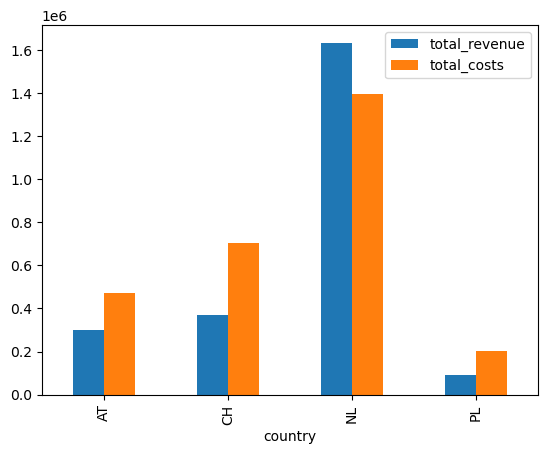

In [155]:
df_country_stats.plot.bar(x='country', y=['total_revenue', 'total_costs'])

In [156]:
# Total costs and marketing costs

<Axes: xlabel='country'>

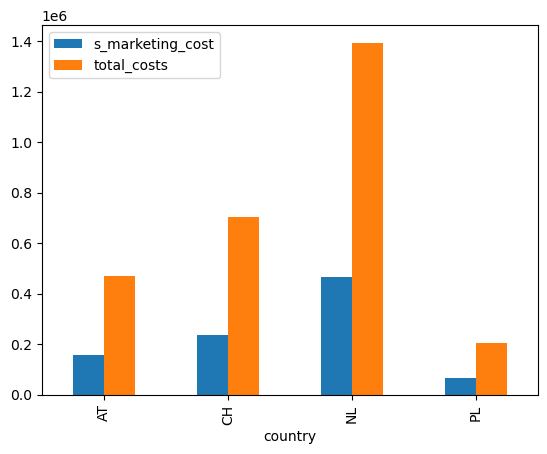

In [157]:
df_country_stats.plot.bar(x='country', y=['s_marketing_cost', 'total_costs'])

In [158]:
# Total revenue, value (turnover) and costs

<Axes: xlabel='country'>

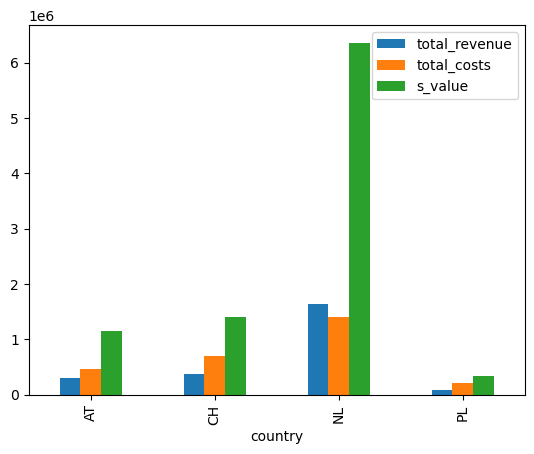

In [159]:
df_country_stats.plot.bar(x='country', y=['total_revenue', 'total_costs', 's_value' ])

In [160]:
# Unique restaurants and cities

<Axes: xlabel='country'>

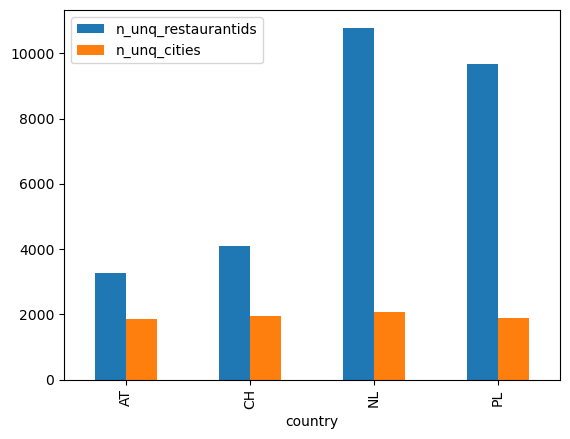

In [161]:
df_country_stats.plot.bar(x='country', y=['n_unq_restaurantids', 'n_unq_cities'])

In [162]:
# Average order value, average order price

<Axes: xlabel='country'>

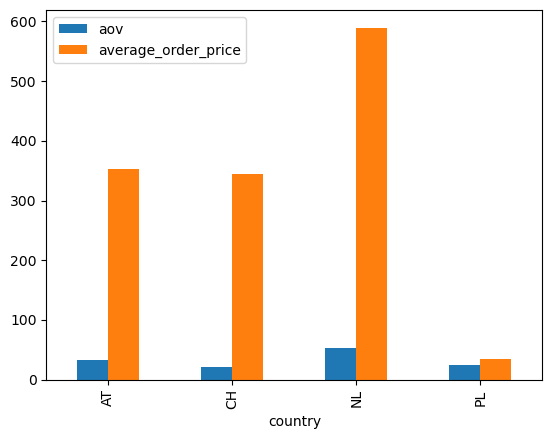

In [163]:
df_country_stats.plot.bar(x='country', y=['aov', 'average_order_price'])

The best indicators are in NL and here the business is profitable.

- Orders are the most expensive in NL (the value of the average order's price)
- NL has a biggest amount of restaurants than other countries, with Poland in second place
- All countries have approximately the same amount of cities, where restaraunts located

Further I want to check the growth of business per months in each countries

In [164]:
def month_stat(df):
    return df.groupby(['order_month'], as_index=False).agg(
                n_trs=pd.NamedAgg(column='transaction_id', aggfunc='count'),
                s_revenue=pd.NamedAgg(column='total_revenue', aggfunc='sum'),
                s_costs=pd.NamedAgg(column='total_costs', aggfunc='sum'),
                s_marketing_costs=pd.NamedAgg(column='marketing_cost_EUR', aggfunc='sum'),
            ) \
            .sort_values('order_month')

In [165]:
tdf = month_stat(overall_business_info)

In [166]:
for country in sorted(overall_business_info['country'].unique()):
    dfc = overall_business_info[overall_business_info['country'] == country]
    df_stat = month_stat(dfc)
    tdf[f'n_trs_{country}'] = df_stat['n_trs']
    tdf[f's_revenue_{country}'] = df_stat['s_revenue']
    tdf[f's_costs_{country}'] = df_stat['s_costs']
    tdf[f's_marketing_costs_{country}'] = df_stat['s_marketing_costs']

In [167]:
tdf

,order_month,n_trs,s_revenue,s_costs,s_marketing_costs,n_trs_AT,s_revenue_AT,s_costs_AT,s_marketing_costs_AT,n_trs_CH,s_revenue_CH,s_costs_CH,s_marketing_costs_CH,n_trs_NL,s_revenue_NL,s_costs_NL,s_marketing_costs_NL,n_trs_PL,s_revenue_PL,s_costs_PL,s_marketing_costs_PL
0,2019-05,2837,6377.28,7199.06,2354.08,241,655.86,959.75,289.52,205,746.22,1952.39,621.70,1717,4710.30,3686.74,1236.03,674,264.90,600.18,206.83
1,2019-06,75278,171247.72,194400.53,64311.64,7990,21247.30,35246.72,11691.59,5645,21906.22,47893.80,15595.07,45118,121889.15,96417.41,32046.27,16525,6205.05,14842.59,4978.71
2,2019-07,73237,167604.51,183832.94,61236.98,7597,20574.52,30661.05,10159.19,5738,22345.82,47382.39,16006.45,43692,118562.56,91664.62,30362.94,16210,6121.61,14124.87,4708.40
3,2019-08,73351,168886.52,180494.67,60419.40,7794,21202.86,30854.75,10272.80,6001,24443.54,49737.65,16501.00,43039,117140.56,85632.28,28924.72,16517,6099.57,14269.99,4720.89
4,2019-09,74858,170538.23,190139.87,63340.85,7996,21738.30,32914.96,11106.06,6180,24165.94,50396.58,16636.58,43245,118185.89,91412.17,30477.30,17437,6448.09,15416.16,5120.91
5,2019-10,79452,181936.57,223992.31,74230.82,8313,22380.35,45743.66,15091.25,6476,25878.76,55408.58,18408.46,45792,126592.77,105937.47,35074.93,18871,7084.69,16902.60,5656.18
6,2019-11,80834,186366.28,213283.43,70707.65,8595,24289.37,41045.45,13711.64,6843,27297.69,57594.66,19159.98,45869,127288.25,98211.84,32412.41,19527,7490.97,16431.48,5423.63
7,2019-12,83658,197170.97,239664.14,80185.04,9391,26299.77,42120.68,14044.91,7619,31428.50,62668.68,21157.02,46846,131713.77,117574.44,39192.13,19802,7728.93,17300.34,5790.99
8,2020-01,85387,197529.10,254788.05,84604.89,9131,25784.10,41214.98,13638.15,7522,31193.45,61386.33,20282.72,47582,132329.03,134720.68,44823.73,21152,8222.52,17466.06,5860.29
9,2020-02,80809,188162.93,274306.59,91583.56,8271,23624.34,47330.07,15791.00,6901,29173.34,57435.01,19372.26,44740,127055.26,148853.01,49533.67,20897,8309.99,20688.50,6886.63


In [168]:
# Total transactions and revenue per months

<Axes: xlabel='order_month'>

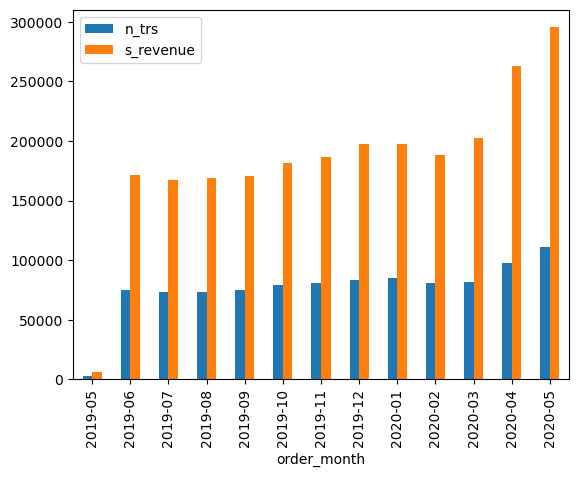

In [169]:
tdf.plot.bar(x='order_month', y=['n_trs', 's_revenue'])

<Axes: xlabel='order_month'>

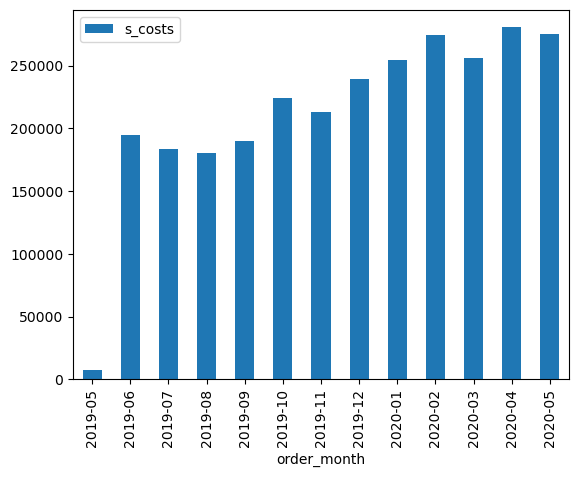

In [170]:
tdf.plot.bar(x='order_month', y=['s_costs'])

<Axes: xlabel='order_month'>

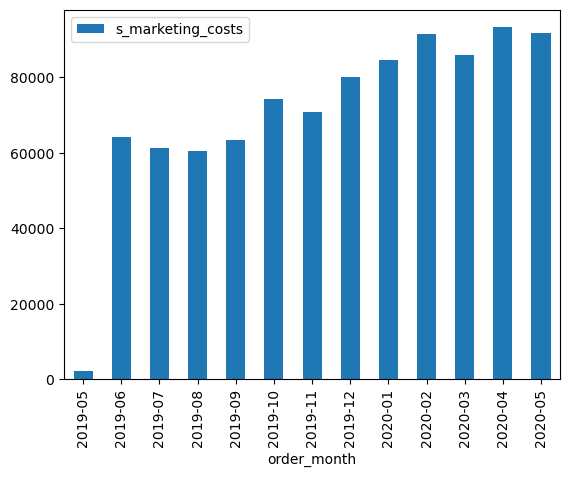

In [171]:
tdf.plot.bar(x='order_month', y=['s_marketing_costs'])

<Axes: xlabel='order_month'>

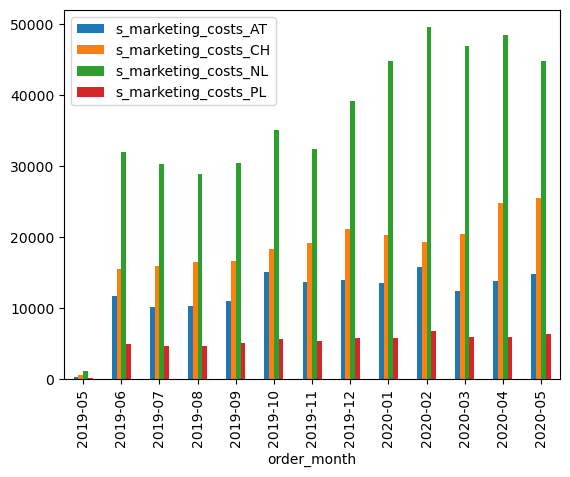

In [172]:
tdf.plot.bar(x='order_month', y=['s_marketing_costs_AT', 's_marketing_costs_CH', 's_marketing_costs_NL', 's_marketing_costs_PL'])

In [173]:
# Transactions per countries and months

<Axes: xlabel='order_month'>

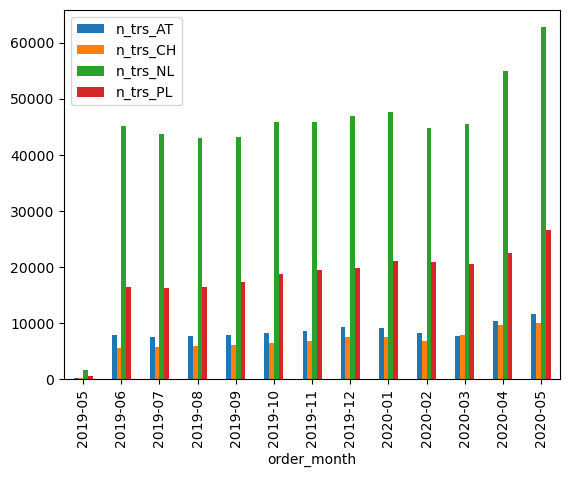

In [174]:
tdf.plot.bar(x='order_month', y=['n_trs_AT', 'n_trs_CH', 'n_trs_NL', 'n_trs_PL'])

In [175]:
# Revenue per countries 

<Axes: xlabel='order_month'>

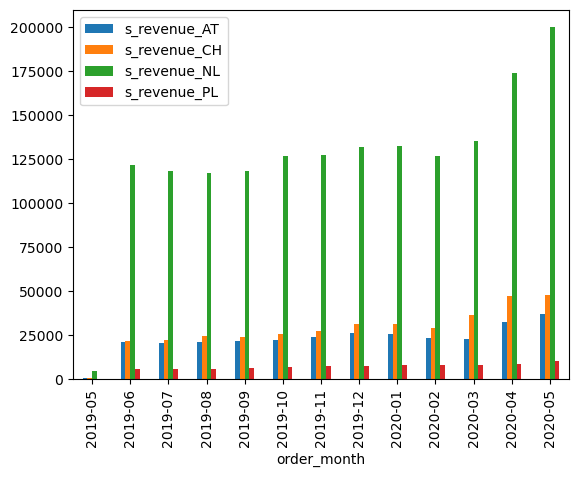

In [176]:
tdf.plot.bar(x='order_month', y=['s_revenue_AT', 's_revenue_CH', 's_revenue_NL', 's_revenue_PL'])

- Revenue and transcations have increased significantly over the past 2 months of dataset (2020-04, 2020-05)

<Axes: xlabel='order_month'>

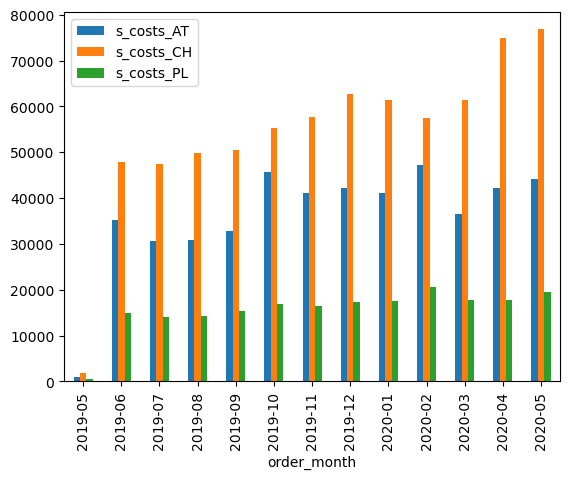

In [177]:
tdf.plot.bar(x='order_month', y=['s_costs_AT', 's_costs_CH', 's_costs_PL'])

### 1.3 Create a consumer cohort analysis and identify the good and bad cohorts, Can you explain why?

In [178]:
def unique_users(df):
    return set(df['userid'])

In [179]:
def set_percentage_agg(orig, cur):
    return len(orig & cur) * 1.0 / len(orig)

In [180]:
def stat_from_month_in_cur_month(df, month_from, month_cur, f, agg_f):
    df_month_from = df[df['session_month'] == month_from]
    df_month_cur  = df[df['session_month'] == month_cur ]
    f_month_from = f(df_month_from)
    f_month_cur  = f(df_month_cur )
    return agg_f(f_month_from, f_month_cur)

In [181]:
def cohorts_stat(df, f, agg_f=set_percentage_agg):
    months = sorted(set(df[df['session_month'].notna()]['session_month']))
    dicts = []
    for i, month in enumerate(months):
        n_users = len(f(df[df['session_month'] == month]))
        d = {'cohort': month, 'n_users': n_users}
        for j in range(i + 1, len(months)):
            diff = j - i
            month_cur = months[j]
            stat = stat_from_month_in_cur_month(df, month, month_cur, f, agg_f)
            d[f'T+{diff}'] = stat
        dicts.append(d)
    return pd.DataFrame(dicts)

In [182]:
# Cohorts by months and all countries

In [183]:
cohorts_stat(df_engagements_final, unique_users)

,cohort,n_users,T+1,T+2,T+3,T+4,T+5,T+6,T+7,T+8,T+9,T+10,T+11,T+12,T+13
0,2019-05,3036,0.05,0.05,0.04,0.03,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.00
1,2019-06,79909,0.04,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.00,NaN
2,2019-07,78531,0.04,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.00,NaN,NaN
3,2019-08,78410,0.04,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.00,NaN,NaN,NaN
4,2019-09,81862,0.04,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.00,NaN,NaN,NaN,NaN
5,2019-10,86111,0.04,0.04,0.03,0.02,0.02,0.02,0.02,0.00,NaN,NaN,NaN,NaN,NaN
6,2019-11,88413,0.04,0.03,0.03,0.03,0.03,0.03,0.00,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-12,91749,0.04,0.03,0.03,0.03,0.03,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-01,70781,0.05,0.04,0.04,0.04,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-02,57781,0.05,0.05,0.05,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**The highest retention is 6% for the first months, but the average is 2%**

In [184]:
# Platform - WEB

In [185]:
cohorts_stat(df_engagements_final[df_engagements_final['platform'] == 'WEB'], unique_users)

,cohort,n_users,T+1,T+2,T+3,T+4,T+5,T+6,T+7,T+8,T+9,T+10,T+11,T+12,T+13
0,2019-05,212,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2019-06,6477,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN
2,2019-07,6990,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN
3,2019-08,7285,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN
4,2019-09,7235,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN
5,2019-10,7498,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN
6,2019-11,7761,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-12,8185,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-01,8182,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-02,7819,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Users don't return in next months, if they order through WEB**

In [186]:
# Platform - APP

In [187]:
cohorts_stat(df_engagements_final[df_engagements_final['platform'] == 'APP'], unique_users)

,cohort,n_users,T+1,T+2,T+3,T+4,T+5,T+6,T+7,T+8,T+9,T+10,T+11,T+12,T+13
0,2019-05,1887,0.07,0.07,0.06,0.05,0.04,0.05,0.05,0.04,0.03,0.03,0.04,0.04,0.00
1,2019-06,50103,0.05,0.04,0.04,0.04,0.04,0.03,0.03,0.03,0.03,0.03,0.03,0.00,NaN
2,2019-07,48777,0.05,0.05,0.04,0.04,0.04,0.03,0.03,0.03,0.03,0.03,0.00,NaN,NaN
3,2019-08,48866,0.05,0.05,0.04,0.04,0.04,0.03,0.03,0.03,0.03,0.00,NaN,NaN,NaN
4,2019-09,52152,0.06,0.05,0.05,0.04,0.03,0.03,0.03,0.03,0.00,NaN,NaN,NaN,NaN
5,2019-10,55486,0.06,0.05,0.05,0.03,0.04,0.04,0.04,0.00,NaN,NaN,NaN,NaN,NaN
6,2019-11,57091,0.06,0.05,0.04,0.04,0.04,0.04,0.00,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-12,59448,0.06,0.05,0.05,0.05,0.05,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-01,62599,0.05,0.05,0.05,0.05,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-02,49962,0.06,0.06,0.06,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
df = pd.merge(df_engagements_final, df_transactions_final, on='transaction_id')

In [189]:
# Cohorts by months and particular country

**Netherlands**

In [190]:
cohorts_stat(df[df['country'] == 'NL'], unique_users)

,cohort,n_users,T+1,T+2,T+3,T+4,T+5,T+6,T+7,T+8,T+9,T+10,T+11,T+12
0,2019-05,1428,0.03,0.04,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01
1,2019-06,37207,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,NaN
2,2019-07,36319,0.03,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.02,NaN,NaN
3,2019-08,35702,0.03,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,NaN,NaN,NaN
4,2019-09,35795,0.03,0.03,0.02,0.02,0.01,0.01,0.02,0.02,NaN,NaN,NaN,NaN
5,2019-10,37662,0.03,0.02,0.02,0.01,0.01,0.02,0.02,NaN,NaN,NaN,NaN,NaN
6,2019-11,37960,0.03,0.02,0.02,0.01,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-12,36974,0.02,0.02,0.02,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-01,23736,0.03,0.02,0.03,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-02,19471,0.03,0.03,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Poland**

In [191]:
cohorts_stat(df[df['country'] == 'PL'], unique_users)

,cohort,n_users,T+1,T+2,T+3,T+4,T+5,T+6,T+7,T+8,T+9,T+10,T+11,T+12
0,2019-05,560,0.02,0.02,0.02,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.00
1,2019-06,13106,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.01,NaN
2,2019-07,12785,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,NaN,NaN
3,2019-08,12962,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,NaN,NaN,NaN
4,2019-09,13683,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,NaN,NaN,NaN,NaN
5,2019-10,14750,0.02,0.02,0.01,0.01,0.01,0.01,0.01,NaN,NaN,NaN,NaN,NaN
6,2019-11,15498,0.02,0.01,0.01,0.01,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-12,15707,0.01,0.01,0.01,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-01,8200,0.02,0.02,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-02,6719,0.02,0.02,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Austria**

In [192]:
cohorts_stat(df[df['country'] == 'AT'], unique_users)

,cohort,n_users,T+1,T+2,T+3,T+4,T+5,T+6,T+7,T+8,T+9,T+10,T+11,T+12
0,2019-05,207,0.02,0.02,0.03,0.01,0.00,0.00,0.01,0.01,0.00,0.01,0.02,0.02
1,2019-06,6500,0.03,0.03,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,NaN
2,2019-07,6168,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,NaN,NaN
3,2019-08,6292,0.03,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,NaN,NaN,NaN
4,2019-09,6425,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,NaN,NaN,NaN,NaN
5,2019-10,6475,0.03,0.03,0.02,0.01,0.01,0.02,0.01,NaN,NaN,NaN,NaN,NaN
6,2019-11,6766,0.03,0.02,0.01,0.01,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-12,7118,0.02,0.01,0.01,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-01,4547,0.03,0.02,0.02,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-02,3126,0.03,0.03,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Czech Republic**

In [193]:
cohorts_stat(df[df['country'] == 'CH'], unique_users)

,cohort,n_users,T+1,T+2,T+3,T+4,T+5,T+6,T+7,T+8,T+9,T+10,T+11,T+12
0,2019-05,15,0.07,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2019-06,195,0.02,0.01,0.02,0.02,0.01,0.00,0.01,0.00,0.02,0.01,0.02,NaN
2,2019-07,184,0.02,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.00,0.01,NaN,NaN
3,2019-08,255,0.02,0.01,0.01,0.01,0.00,0.00,0.01,0.01,0.00,NaN,NaN,NaN
4,2019-09,210,0.03,0.00,0.00,0.01,0.01,0.00,0.01,0.00,NaN,NaN,NaN,NaN
5,2019-10,282,0.01,0.02,0.01,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN
6,2019-11,268,0.01,0.00,0.00,0.01,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-12,315,0.01,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-01,137,0.01,0.00,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-02,113,0.02,0.01,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
# Very low retention, but the figures are too small for affecting on a whole picture

**Let's look at funnel_level**

**Each session has only 1 funnel_level (deepest level during this session)**

In [195]:
tdf = size_calculation(df_user_engagements, ['sessionid', 'funnel_level'], ['sessionid'])

size_calculation(tdf, ['sessionid'], ['cnt'], ascending=False)

,sessionid,cnt
0,00000458bf8df8985f01ef736b4f3e4ebcd60ea7,1
1,aaa3f64d9b9091ae2f718674f63ce2cd01b188a3,1
2,aaa3fcfa6db5d324002dbfdaacbabe79d1c5e243,1
3,aaa4078f11ba7f81e251aa33c44ebc90dd3f65d7,1
4,aaa416d05544efedd5965f40c01dc5e940a2d920,1
...,...,...
1009526,557a434955e909193a67160a3310d9caf2c60048,1
1009527,557a6e5737f8cf03378858145b3466a5a2de1d39,1
1009528,557a711782cb0d0358384a76ec0704ce975ca76f,1
1009529,557a7dc77ff0c728adf2f570aaa45add0b1a33ae,1


**I created an analysis for funnel_level by months and found some insights.**

But anyway for creating cohort for measuring user's behaviour I need more understandings for the logic for funnel colomn: what is the first event, second event in a process and etc.

Because I see transactions at any funnel_level

In [196]:
dicts = []
for fl in df_engagements_final['funnel_level'].unique():
    dfl = df_engagements_final[df_engagements_final['funnel_level'] == fl]
    sz = dfl.shape[0]
    tr_cnt = dfl[dfl['transaction_id'].notna()].shape[0]
    dicts.append({'funnel_level': fl, 'n_sessions': sz, 'n_sessions_with_transactions': tr_cnt})
stat_by_funnel = pd.DataFrame(dicts)

In [197]:
stat_by_funnel['CR'] = stat_by_funnel['n_sessions_with_transactions'] / stat_by_funnel['n_sessions'] 

In [198]:
dicts = []
for month in sorted(set(df_engagements_final[df_engagements_final['session_month'].notna()]['session_month'])):
    df_month = df_engagements_final[df_engagements_final['session_month'] == month]
    size = df_month.shape[0]
    n_users = len(set(df_month['userid']))
    n_trs = sum(df_month['transaction_id'].notna())
    funnel_level_stat = size_calculation(df_month, ['funnel_level'], ['funnel_level'])
    d = {'month': month, 'n_sessions': size, 'n_users': n_users, 'n_trs': n_trs}
    for i, row in funnel_level_stat.iterrows():
        d[row['funnel_level']] = row['cnt']
    dicts.append(d)
stat_by_month = pd.DataFrame(dicts)

In [199]:
funnel_levels = df_engagements_final[df_engagements_final['funnel_level'].notna()]['funnel_level'].unique()
stat_by_month_frac = stat_by_month.copy()

for c in funnel_levels:
    stat_by_month_frac[c] = stat_by_month_frac[c] / stat_by_month_frac['n_sessions']

**Checking transactions by throght the sessions**

In [200]:
stat_by_funnel

,funnel_level,n_sessions,n_sessions_with_transactions,CR
0,service,457657,223935,0.49
1,menu,147651,18439,0.12
2,confirmation,342728,328553,0.96
3,start,17817,2373,0.13
4,checkout,41135,33688,0.82
5,NaN,0,0,NaN


**Then I checked all funnel statuses by months**

In [201]:
# In absolute figures
stat_by_month

,month,n_sessions,n_users,n_trs,checkout,confirmation,menu,service,start
0,2019-05,3040,3036,2210,38.00,1653,306,1005,38.00
1,2019-06,82613,79909,57936,3178.00,40576,9221,28332,1306.00
2,2019-07,81123,78531,56364,3940.00,39195,9382,27109,1497.00
3,2019-08,80872,78410,56084,4218.00,37644,10401,27085,1524.00
4,2019-09,84694,81862,56998,4427.00,38004,12541,28240,1482.00
5,2019-10,89257,86111,60126,2182.00,34371,11588,39592,1524.00
6,2019-11,91612,88413,61417,1508.00,33539,11397,43563,1605.00
7,2019-12,95296,91749,60982,1479.00,37786,12717,41626,1688.00
8,2020-01,74422,70781,37298,1444.00,18324,12133,41311,1210.00
9,2020-02,60503,57781,29898,3776.00,12470,10698,32429,1130.00


<Axes: xlabel='month'>

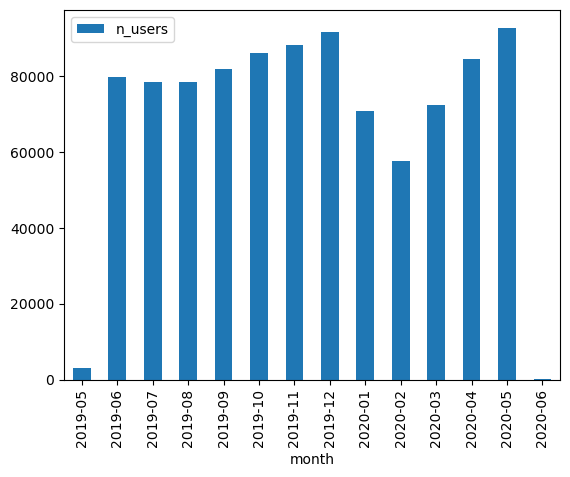

In [202]:
stat_by_month.plot.bar(x='month', y=['n_users'])

In [203]:
# Fraction of all sessions on particular funnel_level

stat_by_month_frac

,month,n_sessions,n_users,n_trs,checkout,confirmation,menu,service,start
0,2019-05,3040,3036,2210,0.01,0.54,0.10,0.33,0.01
1,2019-06,82613,79909,57936,0.04,0.49,0.11,0.34,0.02
2,2019-07,81123,78531,56364,0.05,0.48,0.12,0.33,0.02
3,2019-08,80872,78410,56084,0.05,0.47,0.13,0.33,0.02
4,2019-09,84694,81862,56998,0.05,0.45,0.15,0.33,0.02
5,2019-10,89257,86111,60126,0.02,0.39,0.13,0.44,0.02
6,2019-11,91612,88413,61417,0.02,0.37,0.12,0.48,0.02
7,2019-12,95296,91749,60982,0.02,0.40,0.13,0.44,0.02
8,2020-01,74422,70781,37298,0.02,0.25,0.16,0.56,0.02
9,2020-02,60503,57781,29898,0.06,0.21,0.18,0.54,0.02


- I see, that there are transactions in all funnel levels
- The best CR (Conversion Rate) on **`confirmation level 0.96`**, the second one on **`checkout 0.82`**
- I think something was broken at **`confirmation`** stage, because there is significant drop of transaction since **2020-01 to 2020-04**

## 2. Based on this data, what would you suggest a good KPI to measure customer retention?

There are 2 main metrics for measuring customer retention:
- `Churn Rate`
- `User Retention Rate`

I suppose, the good idea to diversify different groups and measure retention separately, because we could see, that cohorts via different counries and platform are not similar
- Groups by countries
- Groups by platform
- Groups could be segmentated by my approach at Task 1;
- Groups by weeks / months

**User Retention Rate** - 
((Number of Users at the end of the period - Number of Users acquired during the period) / Number of Users at the beggining of the period)) * 100


**Churn Rate** -
(Number of users lost during the period / Number of Users at the beggining of the period) * 100

## 3. What can be the primary KPIs for the company and what can you say about them?

Main KPIs are a broad term that encompasses many different types of KPIs, so the specific
metrics that Kaboom tracks will depend on specific business goals and objectives. However,
there are some metrics that are commonly tracked in the food delivery industry:

KPI ranked by decreasing importance
1. **Average order volume**
2. **On time delivery**
3. **Customer satisfaction**


**1. Average order volume** consists of average orders per restaurant, average orders per cuisine category, average size per restaurant and cuisine category. The AOV metric is helpful for cases where a company wants to predict revenue streams and manage budgets.

It lets you compare one period to another and study contextual changes to see what might be improving or hindering your AOV.
For improving this metric it’s possible to group customers/ restaurants and run targeted promotion campaigns for frequent customers with loyalty programs that rewards them, while low spenders can be targeted with offers and cross-sells to try and improve their
value.
Other methods include:

- Bundling, upselling, and cross-selling additional products and services
- Adding a free shipping threshold
- Applying a set discount on minimum order values

**2. On time delivery** includes time from order received, to processed, to delivered. It tracks the time it takes for an order to be delivered to the customer, from the time the order is placed.
On time delivery is one of the key ways in which customers judge the delivery experience, and therefore a critical factor in customer retention.

Machine learning can help businesses understand what’s going on behind the scenes and why deliveries are late. By using machine learning you‘ll be able to take the information you receive to make smart decisions that lead to improved metric.


**3. Customer satisfaction** tracks how satisfied customers are with the overall experience of
ordering and receiving food through the platform. It helps with understanding:
- How customers rate their experience with the food
- How customers rate their experience with the delivery driver
- How customers rate their experience with the delivery platform

There are many different types of customer satisfaction metrics, depending on their goals and
objectives.
Some of the most commonly used satisfaction metrics include:
- Net Promoter Score (NPS), 
- Churn Rate,
- Customer Lifetime Value (CLV).

**4.Growth of registered user base** 

## 4. Anything else you want to show or say!

I want to conclude my observations:

**1. The original data was not clean**:
- The unique value of each customer is userid, not customerid.
- I believe, that there bugs with `loginid and customerid` - we see  that customerids and loginids are duplicated, while other values are not
- We have transactions without user's information - it could be unauthorised users or just a bug

**2. Description of Cleared Data**
- All data within 1 year: from 2019-05-30 to 2020-05-31
- We have `4 countries` in this dataset: `Netherlands, Austria, Poland and Czech Republic`
- We have `3 currencies`: `EUR, PLN, CHF`. All data was converted to EUR
- We have `793 437 transactions` in df_engagements_final (and `400 000 Null transactions`)
- All transactions (except null) from df_engagements_final represented in df_transactions_final
- `186 449` transactions have no information about users
- There are `206 561` transactions in df_transactions_final, that are only in this table, so we don't know information about userid too


**3. Insights**
1. There is a significant small amount of repeated users per one year!
- Users, who have more than 1 transaction - `52 967`
- Users, who have 1 transaction - `489 885`

2. ROMI - checking the marketing effect
- The best marketing channel = `1`
- Other good marketing channels - `4, 5, 12, 7, 2` (in DESC order)
- The worst are = `9, 13, 18, 10, -1`

3. The overall situation, that the business is not profitable at the moment
- Total Loss = `-377221.38`
- `The best indicators are in NL` (turnover, revenue) and here the business is profitable.
- `Orders are the most expensive in NL` (the value of the average order's price)
- `NL` has a biggest amount of restaurants than other countries, with `Poland` in second place
- All countries have approximately the same amount of cities, where restaraunts located

4. Retention
- Users don't return in next months, if they order through `WEB`
- The highest retention is 6% for the first months, but the average is 2%
- The best CR (Conversion Rate) on confirmation level `0.96`, the second one on checkout `0.82`
- I think something was broken at confirmation stage, because there is significant drop of transaction since `2020-01 to 2020-04`

5. Metrics

- User Retention Rate / Churn Rate 
- Average order volume 
- On time delivery 
- Customer satisfaction
- Growth of registered user base